In [1]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsforecast

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [1125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import scipy.stats as st
import seaborn as sns
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from pmdarima import auto_arima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ndiffs
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from hyperopt import fmin, tpe, hp
from hyperopt import STATUS_OK
import shap 
import tensorflow
import random
import time

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Pre-processing the raw data
- Feature selection
- Feature Engineering

### Historical Load Data

In [210]:
his_df = pd.read_csv('/Users/shanliang/Desktop/MasterThesis/raw_data/his_data_raw.csv',index_col = 0) # load the data

In [211]:
his_df.shape 

(26280, 11)

In [212]:
his_df.head()

MeasureItem           DateUTC   DateShort  TimeFrom   
0  Monthly Hourly Load Values  01/01/2021 00:00  01/01/2021  00:00:00  \
1  Monthly Hourly Load Values  01/01/2021 01:00  01/01/2021  01:00:00   
2  Monthly Hourly Load Values  01/01/2021 02:00  01/01/2021  02:00:00   
3  Monthly Hourly Load Values  01/01/2021 03:00  01/01/2021  03:00:00   
4  Monthly Hourly Load Values  01/01/2021 04:00  01/01/2021  04:00:00   

     TimeTo CountryCode  Cov_ratio       Value  Value_ScaleTo100   
0  01:00:00          NL        100  11313.1375        11313.1375  \
1  02:00:00          NL        100  10925.1475        10925.1475   
2  03:00:00          NL        100  10576.8200        10576.8200   
3  04:00:00          NL        100  10371.1225        10371.1225   
4  05:00:00          NL        100  10420.2075        10420.2075   

         UpdateDate CreateDate  
0  12/04/2023 11:44        NaN  
1  12/04/2023 11:44        NaN  
2  12/04/2023 11:44        NaN  
3  12/04/2023 11:44        NaN  
4  12/04/2023 11:44        NaN

### https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [213]:
his_df = his_df.set_index('DateUTC')
his_df.index = pd.to_datetime(his_df.index,format='mixed')

# Feature Engineering -- calendar features
def create_features(df):
    # Create time series features based on time series index
    df = df.copy()
    df['Hour'] = df.index.hour
    df['DayofWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    return df
    
his_df = create_features(his_df)

# adding holidays as one of the calendar features
nl_holidays = holidays.country_holidays('NL')
his_df['isHoliday?'] = his_df.index.to_series().apply(lambda x: 1 if x in nl_holidays else 0)

In [214]:
his_df.head(5)

MeasureItem   DateShort  TimeFrom   
DateUTC                                                                 
2021-01-01 00:00:00  Monthly Hourly Load Values  01/01/2021  00:00:00  \
2021-01-01 01:00:00  Monthly Hourly Load Values  01/01/2021  01:00:00   
2021-01-01 02:00:00  Monthly Hourly Load Values  01/01/2021  02:00:00   
2021-01-01 03:00:00  Monthly Hourly Load Values  01/01/2021  03:00:00   
2021-01-01 04:00:00  Monthly Hourly Load Values  01/01/2021  04:00:00   

                       TimeTo CountryCode  Cov_ratio       Value   
DateUTC                                                            
2021-01-01 00:00:00  01:00:00          NL        100  11313.1375  \
2021-01-01 01:00:00  02:00:00          NL        100  10925.1475   
2021-01-01 02:00:00  03:00:00          NL        100  10576.8200   
2021-01-01 03:00:00  04:00:00          NL        100  10371.1225   
2021-01-01 04:00:00  05:00:00          NL        100  10420.2075   

                     Value_ScaleTo100        UpdateDate CreateDate  Hour   
DateUTC                                                                    
2021-01-01 00:00:00        11313.1375  12/04/2023 11:44        NaN     0  \
2021-01-01 01:00:00        10925.1475  12/04/2023 11:44        NaN     1   
2021-01-01 02:00:00        10576.8200  12/04/2023 11:44        NaN     2   
2021-01-01 03:00:00        10371.1225  12/04/2023 11:44        NaN     3   
2021-01-01 04:00:00        10420.2075  12/04/2023 11:44        NaN     4   

                     DayofWeek  Month  isHoliday?  
DateUTC                                            
2021-01-01 00:00:00          4      1           1  
2021-01-01 01:00:00          4      1           1  
2021-01-01 02:00:00          4      1           1  
2021-01-01 03:00:00          4      1           1  
2021-01-01 04:00:00          4      1           1

In [16]:
his_df.isna().sum() # check missing values

MeasureItem             0
DateShort               0
TimeFrom                0
TimeTo                  0
CountryCode             0
Cov_ratio               0
Value                   0
Value_ScaleTo100        0
UpdateDate           8760
CreateDate          17520
Hour                    0
DayofWeek               0
Month                   0
isHoliday?              0
dtype: int64

In [17]:
# important feature selection
selected_columns = ['MeasureItem','TimeFrom','TimeTo','Value','Hour','DayofWeek','Month','isHoliday?']
his_df = his_df[selected_columns]

In [18]:
his_df.isna().sum()

MeasureItem    0
TimeFrom       0
TimeTo         0
Value          0
Hour           0
DayofWeek      0
Month          0
isHoliday?     0
dtype: int64

In [19]:
print(his_df.head())
print(his_df.tail())

                                    MeasureItem  TimeFrom    TimeTo   
DateUTC                                                               
2021-01-01 00:00:00  Monthly Hourly Load Values  00:00:00  01:00:00  \
2021-01-01 01:00:00  Monthly Hourly Load Values  01:00:00  02:00:00   
2021-01-01 02:00:00  Monthly Hourly Load Values  02:00:00  03:00:00   
2021-01-01 03:00:00  Monthly Hourly Load Values  03:00:00  04:00:00   
2021-01-01 04:00:00  Monthly Hourly Load Values  04:00:00  05:00:00   

                          Value  Hour  DayofWeek  Month  isHoliday?  
DateUTC                                                              
2021-01-01 00:00:00  11313.1375     0          4      1           1  
2021-01-01 01:00:00  10925.1475     1          4      1           1  
2021-01-01 02:00:00  10576.8200     2          4      1           1  
2021-01-01 03:00:00  10371.1225     3          4      1           1  
2021-01-01 04:00:00  10420.2075     4          4      1           1  
            

In [1556]:
#save his_df
his_df.to_csv('/Users/shanliang/Desktop/MasterThesis/df/his_df.csv')

### Weather Data

In [21]:
weather_data_total = pd.read_excel('/Users/shanliang/Desktop/MasterThesis/raw_data/weather_data.xlsx') # load the data

In [22]:
weather_data_total['YYYYMMDD'] = pd.to_datetime(weather_data_total['YYYYMMDD'], format='%Y%m%d') 
weather_data = weather_data_total[weather_data_total['YYYYMMDD'] <= '2023-12-31'] # select data before 2024-1-1
weather_data = weather_data.set_index('YYYYMMDD')

# important feature selection using corelation coefficient
selected_columns = ['FH', 'T', 'TD','SQ','RH','DR','Q','P','N','U']
weather_df_10 = weather_data[selected_columns]
# mean wind speed, temperature, dew point temperature, sunshine duration, 
# precipitation duration, hourly precipitation amount, global radiation, 
# air pressure, cloud cover, and relative atmospheric humidity

In [23]:
correlation_matrix = weather_df_10.corr()

In [24]:
correlation_matrix 

FH         T        TD        SQ        RH        DR         Q   
FH  1.000000  0.052963 -0.094187  0.100029  0.110748  0.200687  0.152129  \
T   0.052963  1.000000  0.839264  0.412462 -0.003741 -0.088427  0.531611   
TD -0.094187  0.839264  1.000000  0.057456  0.083343  0.049206  0.154445   
SQ  0.100029  0.412462  0.057456  1.000000 -0.094681 -0.188103  0.779519   
RH  0.110748 -0.003741  0.083343 -0.094681  1.000000  0.588486 -0.079173   
DR  0.200687 -0.088427  0.049206 -0.188103  0.588486  1.000000 -0.154696   
Q   0.152129  0.531611  0.154445  0.779519 -0.079173 -0.154696  1.000000   
P  -0.340923 -0.051238 -0.151670  0.172367 -0.188451 -0.332989  0.130796   
N   0.140024 -0.042156  0.117191 -0.362666  0.108695  0.206379 -0.202232   
U  -0.287431 -0.495057  0.046712 -0.662878  0.152297  0.263309 -0.717378   

           P         N         U  
FH -0.340923  0.140024 -0.287431  
T  -0.051238 -0.042156 -0.495057  
TD -0.151670  0.117191  0.046712  
SQ  0.172367 -0.362666 -0.662878  
RH -0.188451  0.108695  0.152297  
DR -0.332989  0.206379  0.263309  
Q   0.130796 -0.202232 -0.717378  
P   1.000000 -0.236210 -0.145745  
N  -0.236210  1.000000  0.247126  
U  -0.145745  0.247126  1.000000

In [25]:
selected_columns = ['HH','FH', 'T','RH','DR','Q','P','N'] # 7 key features will be used in modeling
weather_df = weather_data[selected_columns] 

weather_df = weather_df.rename(columns={'HH':'Hour','FH':'WindSpeed','T':'Temperature',
                                        'RH':'PrecipitationAmount','DR':'PrecipitationDuration','Q':'GlobalRadiation',
                                       'P':'AirPressure','N':'CloudCover'})

weather_df.to_csv('/Users/shanliang/Desktop/MasterThesis/df/weather_df.csv') # save weather_df

In [26]:
weather_df.head()

Hour  WindSpeed  Temperature  PrecipitationAmount   
YYYYMMDD                                                        
2021-01-01     1         10          -25                    0  \
2021-01-01     2         10          -32                    0   
2021-01-01     3         20          -27                    0   
2021-01-01     4         20          -11                    0   
2021-01-01     5         20           11                    0   

            PrecipitationDuration  GlobalRadiation  AirPressure  CloudCover  
YYYYMMDD                                                                     
2021-01-01                      0              0.0        10059           0  
2021-01-01                      0              0.0        10061           1  
2021-01-01                      0              0.0        10064           7  
2021-01-01                      0              0.0        10064           8  
2021-01-01                      0              0.0        10064           8

In [27]:
weather_df2 = weather_df.copy()
weather_df2.drop('Hour',axis=1,inplace=True)
his_df2 = his_df.copy()

In [28]:
weather_df2.head()

WindSpeed  Temperature  PrecipitationAmount   
YYYYMMDD                                                  
2021-01-01         10          -25                    0  \
2021-01-01         10          -32                    0   
2021-01-01         20          -27                    0   
2021-01-01         20          -11                    0   
2021-01-01         20           11                    0   

            PrecipitationDuration  GlobalRadiation  AirPressure  CloudCover  
YYYYMMDD                                                                     
2021-01-01                      0              0.0        10059           0  
2021-01-01                      0              0.0        10061           1  
2021-01-01                      0              0.0        10064           7  
2021-01-01                      0              0.0        10064           8  
2021-01-01                      0              0.0        10064           8

In [29]:
df = pd.concat([his_df2.reset_index(),weather_df2.reset_index(drop=True)], axis=1)
features = ['DateUTC','MeasureItem','TimeFrom','TimeTo','Value','Hour','DayofWeek','Month','isHoliday?',
           'WindSpeed','Temperature','PrecipitationAmount','PrecipitationDuration','GlobalRadiation','AirPressure','CloudCover']
df = df[features]
df = df.set_index('DateUTC')
df.index = pd.to_datetime(df.index,format='mixed')
#the final dataset consisting of historical load,calendarand weather features
df.to_csv('/Users/shanliang/Desktop/MasterThesis/raw_data/df.csv') 

# Exploratory Data Analysis
- Understand the characteristics and patterns of the time-series data, such as stationarity, autocorrelation, seasonality, trend, and outliers

In [31]:
df.head()

MeasureItem  TimeFrom    TimeTo   
DateUTC                                                               
2021-01-01 00:00:00  Monthly Hourly Load Values  00:00:00  01:00:00  \
2021-01-01 01:00:00  Monthly Hourly Load Values  01:00:00  02:00:00   
2021-01-01 02:00:00  Monthly Hourly Load Values  02:00:00  03:00:00   
2021-01-01 03:00:00  Monthly Hourly Load Values  03:00:00  04:00:00   
2021-01-01 04:00:00  Monthly Hourly Load Values  04:00:00  05:00:00   

                          Value  Hour  DayofWeek  Month  isHoliday?   
DateUTC                                                               
2021-01-01 00:00:00  11313.1375     0          4      1           1  \
2021-01-01 01:00:00  10925.1475     1          4      1           1   
2021-01-01 02:00:00  10576.8200     2          4      1           1   
2021-01-01 03:00:00  10371.1225     3          4      1           1   
2021-01-01 04:00:00  10420.2075     4          4      1           1   

                     WindSpeed  Temperature  PrecipitationAmount   
DateUTC                                                            
2021-01-01 00:00:00         10          -25                    0  \
2021-01-01 01:00:00         10          -32                    0   
2021-01-01 02:00:00         20          -27                    0   
2021-01-01 03:00:00         20          -11                    0   
2021-01-01 04:00:00         20           11                    0   

                     PrecipitationDuration  GlobalRadiation  AirPressure   
DateUTC                                                                    
2021-01-01 00:00:00                      0              0.0        10059  \
2021-01-01 01:00:00                      0              0.0        10061   
2021-01-01 02:00:00                      0              0.0        10064   
2021-01-01 03:00:00                      0              0.0        10064   
2021-01-01 04:00:00                      0              0.0        10064   

                     CloudCover  
DateUTC                          
2021-01-01 00:00:00           0  
2021-01-01 01:00:00           1  
2021-01-01 02:00:00           7  
2021-01-01 03:00:00           8  
2021-01-01 04:00:00           8

In [32]:
min_value = df['Value'].min()
max_value = df['Value'].max()
diff = min_value-max_value
print(min_value)
print(max_value)
print(diff) # the range is large, therefore need normalization 

5383.185
20059.6425
-14676.4575


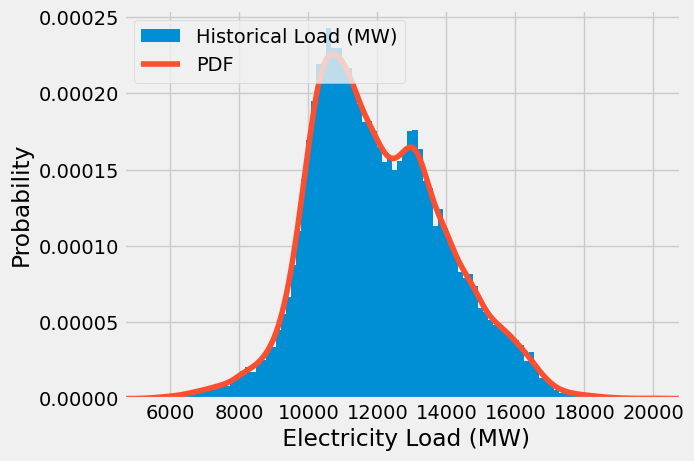

In [1539]:
# histogram
plt.hist(his_df['Value'], density=True, bins=100, label="Historical Load (MW)")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(his_df['Value'])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel(" Electricity Load (MW)")
#plt.title("Electricity Consumption")
plt.savefig("Electricity Consumption.pdf", bbox_inches = 'tight')

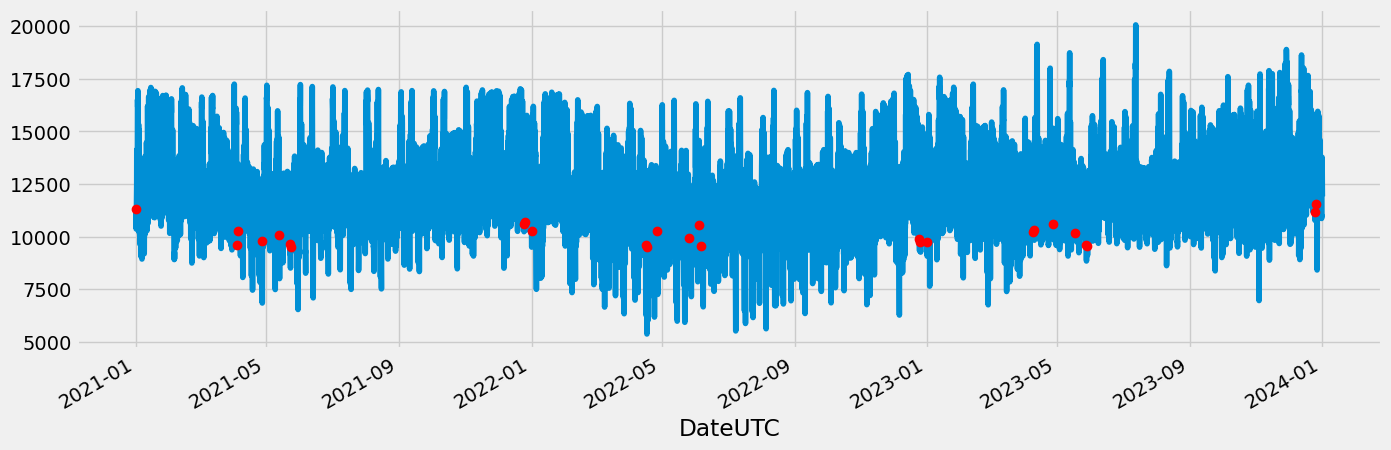

In [1543]:
# Plot electricity load over three years
ax = his_df['Value'].plot(style='-', figsize=(15, 5), color=color_pal[0])

# Plot holidays as dots
holiday_dates = nl_holidays.keys()  # Assuming nl_hldys contains holiday dates
holiday_values = his_df.loc[his_df.index.isin(holiday_dates), 'Value']
ax.plot(holiday_values.index, holiday_values, 'ro')  # Plot holidays as red dots
plt.savefig("Electricity Load Over Three Years.pdf", bbox_inches = 'tight')
plt.show()

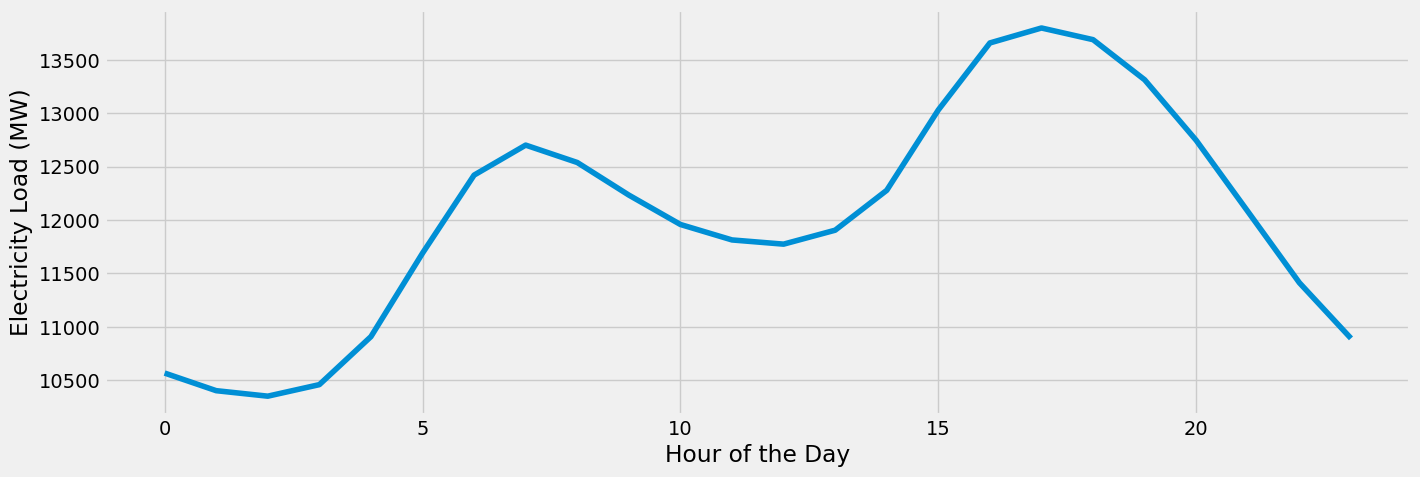

In [1549]:
# average hourly pattern plots
hourly_data = his_df.groupby(his_df.index.hour)['Value'].mean()  # Aggregate data by hour
hourly_data.plot(figsize=(15, 5))
plt.xlabel('Hour of the Day')
plt.ylabel('Electricity Load (MW)')
plt.grid(True)
plt.savefig("Average Hourly Pattern.pdf", bbox_inches = 'tight')

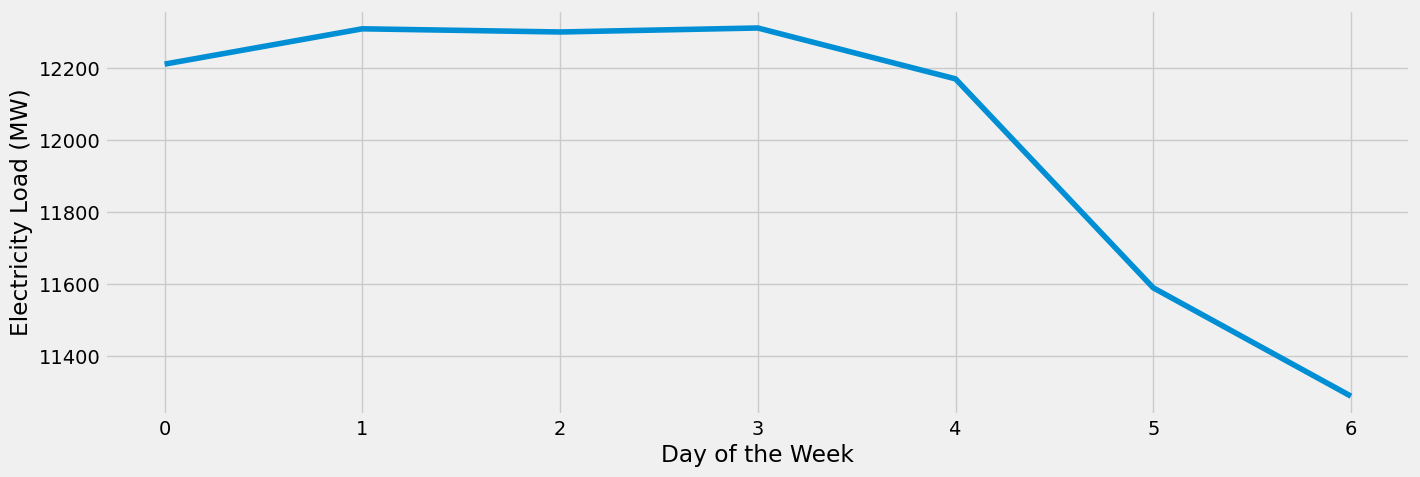

In [1550]:
# average weekly pattern plot
weekly_data = his_df.groupby(his_df.index.dayofweek)['Value'].mean() # Aggregate data by day of week
weekly_data.plot(figsize=(15, 5))
plt.xlabel('Day of the Week')
plt.ylabel('Electricity Load (MW)')
plt.grid(True)
plt.savefig("Average Weekly Pattern.pdf", bbox_inches = 'tight')
plt.show() 

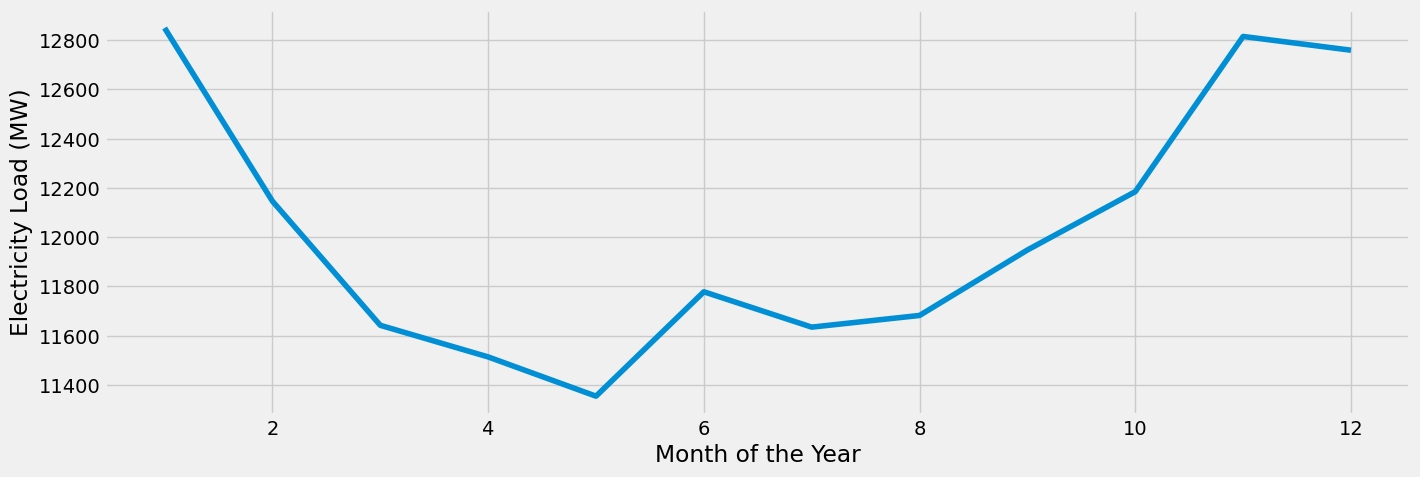

In [1551]:
# average monthly pattern plot
monthly_data = his_df.groupby(his_df.index.month)['Value'].mean()  # Aggregate data by month
monthly_data.plot(figsize=(15, 5))
plt.xlabel('Month of the Year')
plt.ylabel('Electricity Load (MW)')
plt.grid(True)
plt.savefig("Average Monthly Pattern.pdf", bbox_inches = 'tight')
plt.show()

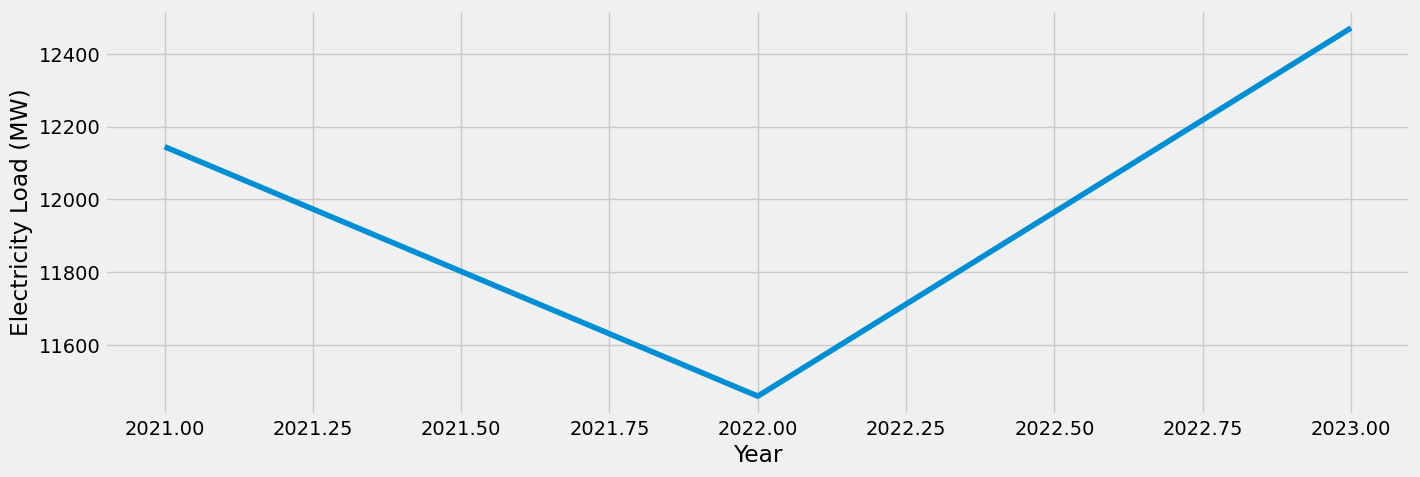

In [1552]:
# average monthly pattern plot
monthly_data = his_df.groupby(his_df.index.year)['Value'].mean()  # Aggregate data by month
monthly_data.plot(figsize=(15, 5))
plt.xlabel('Year')
plt.ylabel('Electricity Load (MW)')
plt.grid(True)
plt.savefig("Average Yearly Pattern.pdf", bbox_inches = 'tight')
plt.show()

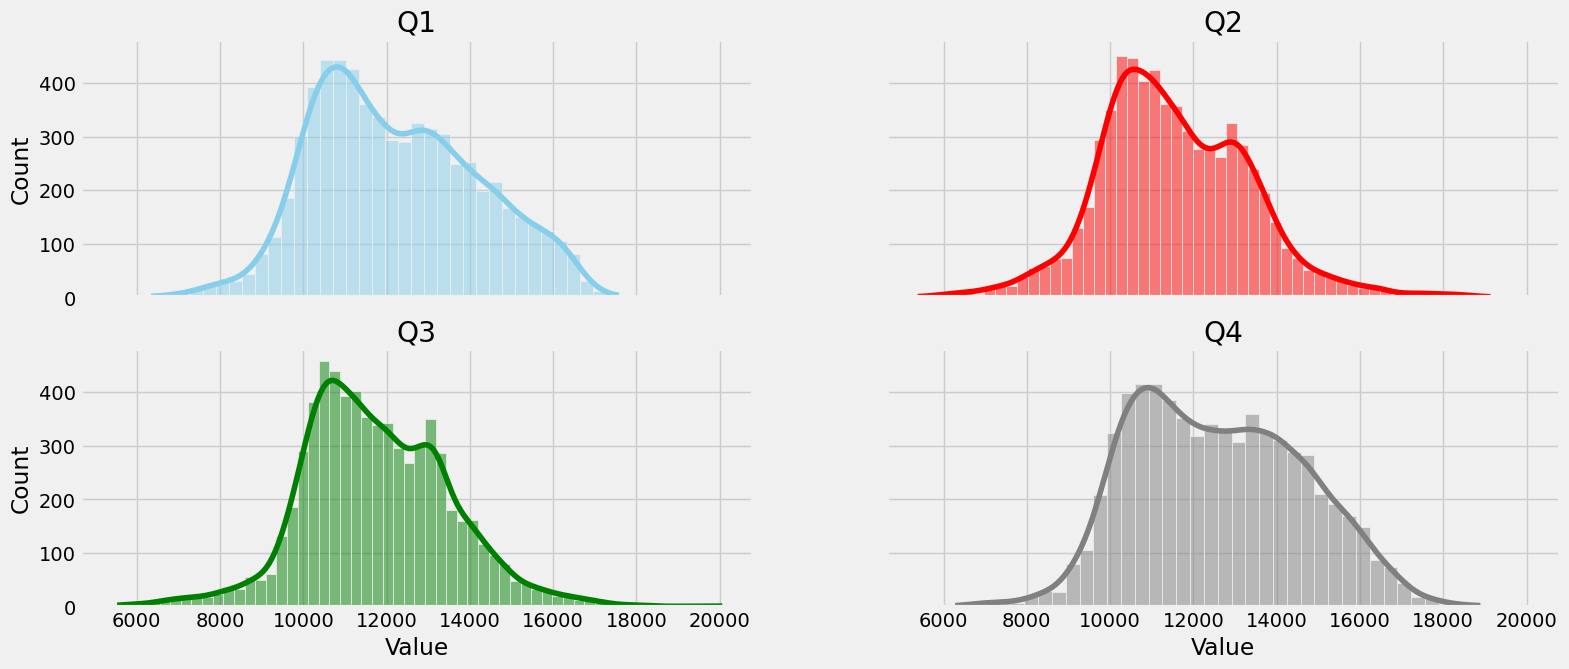

In [1548]:
# quarters plot
Q1 = his_df[(his_df["Month"] >= 1) & (his_df["Month"] <= 3)]
Q2 = his_df[(his_df["Month"] >= 4) & (his_df["Month"] <= 6)]
Q3 = his_df[(his_df["Month"] >= 7) & (his_df["Month"] <= 9)]
Q4 = his_df[(his_df["Month"] >= 10) & (his_df["Month"] <= 12)]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(17, 7), sharex=True, sharey=True)

sns.histplot(Q1["Value"], color="skyblue", ax=axes[0, 0],kde=True).set_title("Q1")
sns.histplot(Q2["Value"], color="red", ax=axes[0, 1],kde=True).set_title("Q2")
sns.histplot(Q3["Value"], color="green", ax=axes[1, 0],kde=True).set_title("Q3")
sns.histplot(Q4["Value"], color="gray", ax=axes[1, 1],kde=True).set_title("Q4")
plt.savefig("Quarterly Electricity Consumption.pdf", bbox_inches = 'tight')
plt.show()

# Checking Missing Value

In [45]:
missing_values = df.isna().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
MeasureItem              0
TimeFrom                 0
TimeTo                   0
Value                    0
Hour                     0
DayofWeek                0
Month                    0
isHoliday?               0
WindSpeed                0
Temperature              0
PrecipitationAmount      0
PrecipitationDuration    0
GlobalRadiation          0
AirPressure              0
CloudCover               0
dtype: int64


In [47]:
df.head()
dataframe = df.copy() # make copy of orginial df

#### Despite the conflicting results from the KPSS and ADF tests, the historical load data is considered non-stationary due to the presence of a hourly pattern observed in the ACF plot

# SARIMA (baseline)

## Staionary Test

### Dickey Fuller Test¶

In [235]:
def check_stationarity(X):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(X)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

X = df.Value
check_stationarity(X)

ADF Statistic: -11.416633
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


### KPSS Test

In [237]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
kpss_test = kpss(df['Value'])
# H0 is staionary
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
# p-value < 0.05. Therefore we reject the null-hypothesis, which means the data is not stationary

KPSS Statistic: 2.493018
Critical Values @ 0.05: 0.46
p-value: 0.010000


## Despite the conflicting results from the KPSS and ADF tests, the historical load data is considered non-stationary due to the presence of a daily pattern observed in the ACF plot


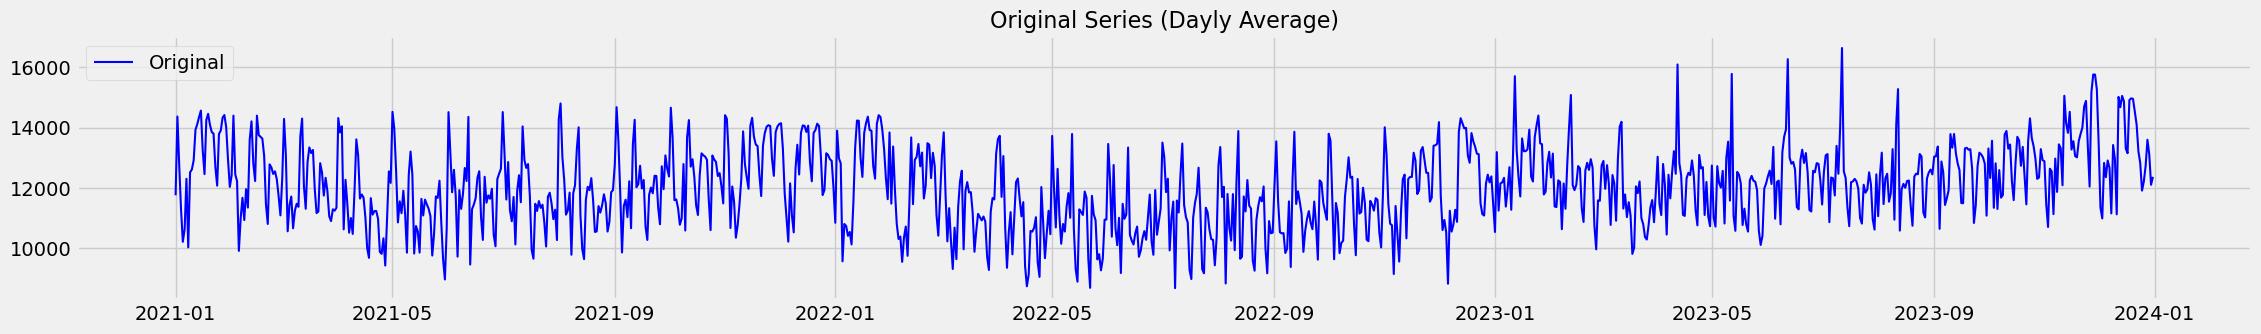

In [240]:
plt.figure(figsize=(25, 15))  
plt.subplot(411)
plt.plot(df['Value'].resample('d').mean(), label='Original', linewidth=1.5, color='blue')
plt.title('Original Series (Daily Average)', fontsize=16)
plt.legend()

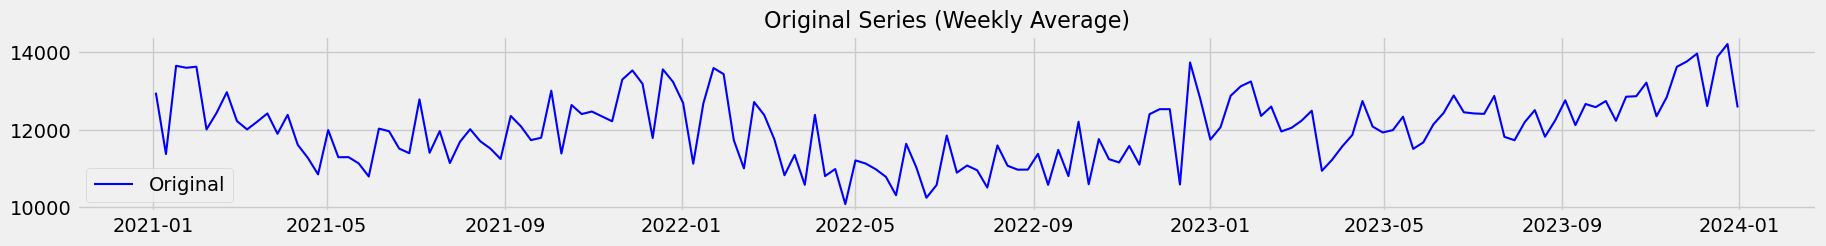

In [241]:
plt.figure(figsize=(20, 10))  
plt.subplot(411)
plt.plot(df['Value'].resample('w').mean(), label='Original', linewidth=1.5, color='blue')
plt.title('Original Series (Weekly Average)', fontsize=16)
plt.legend()

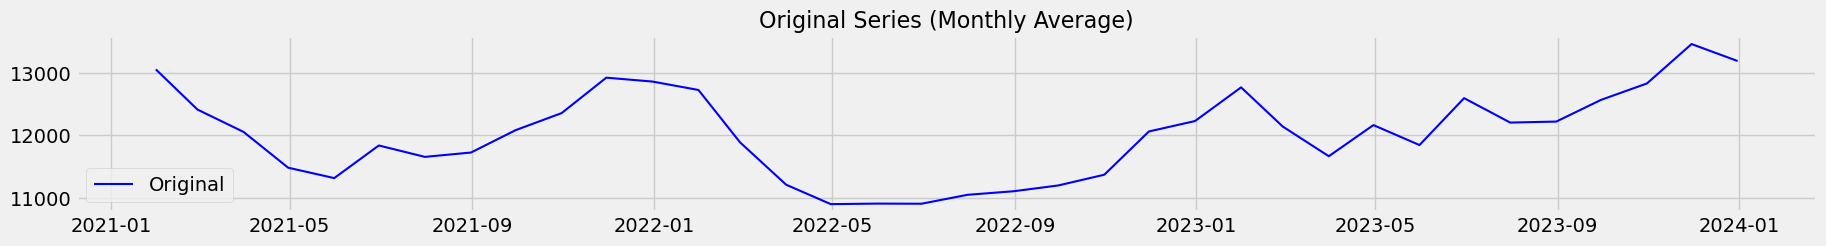

In [242]:
plt.figure(figsize=(20, 10))  
plt.subplot(411)
plt.plot(df['Value'].resample('m').mean(), label='Original', linewidth=1.5, color='blue')
plt.title('Original Series (Monthly Average)', fontsize=16)
plt.legend()

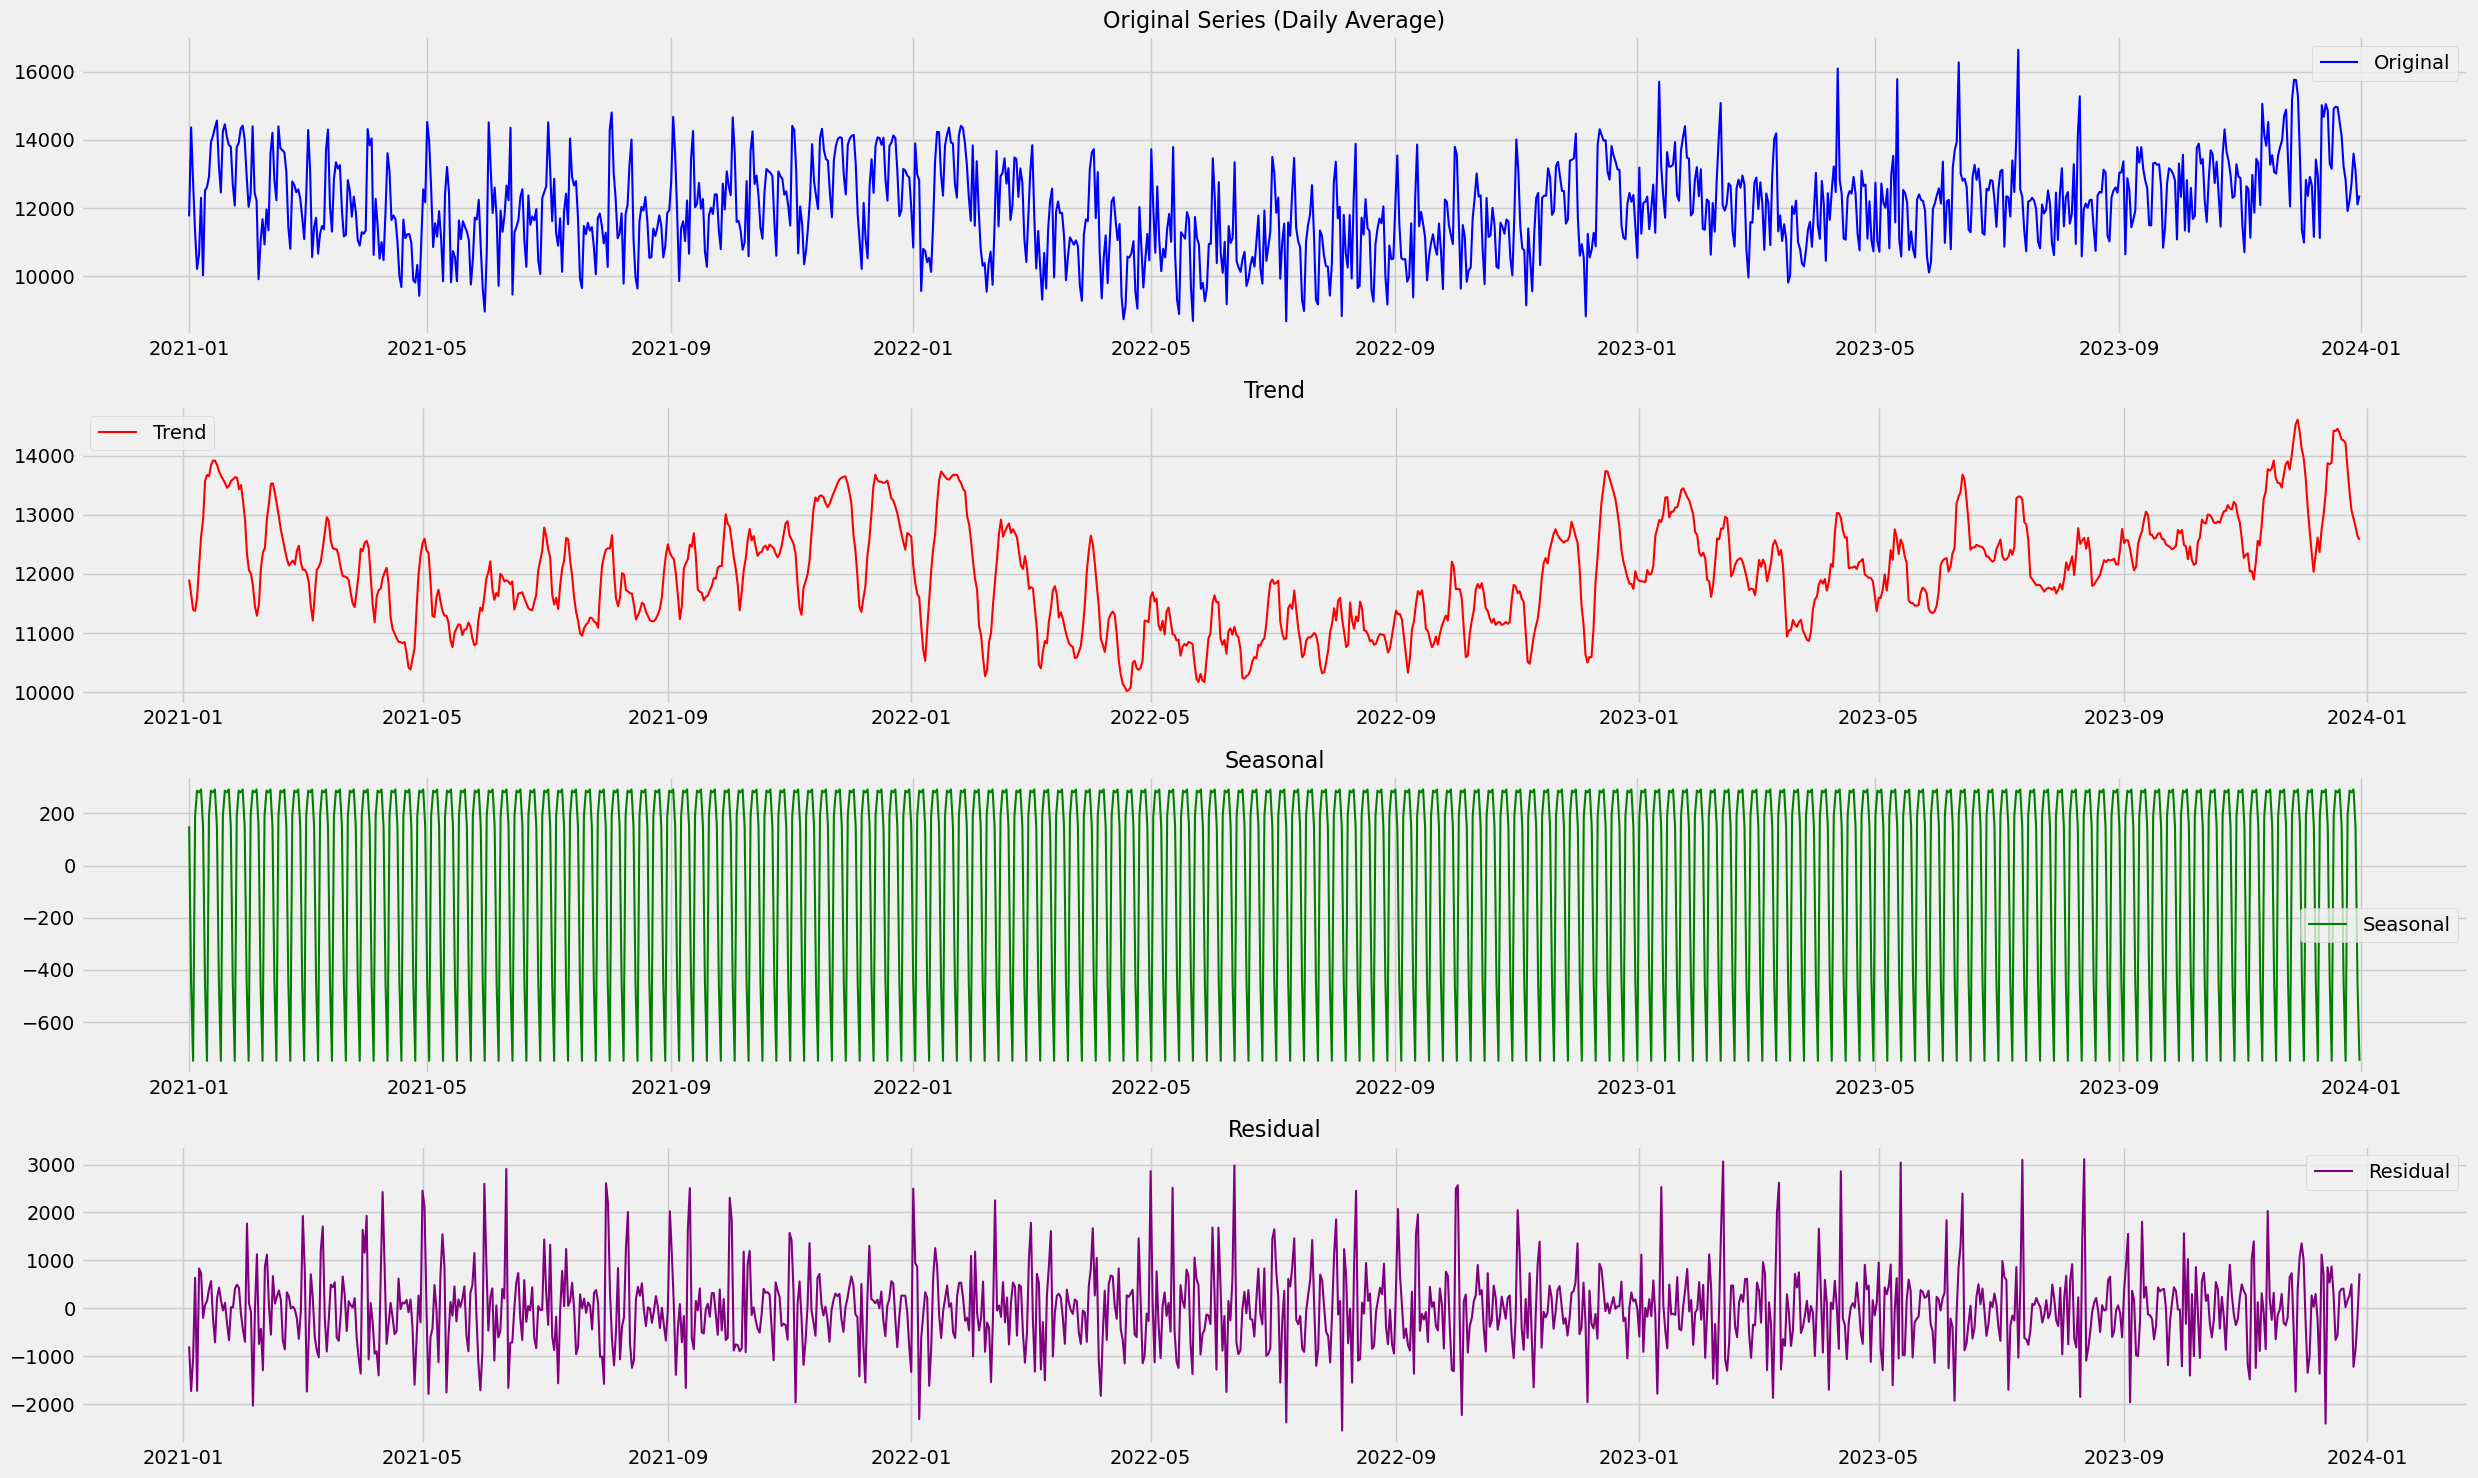

In [243]:
# Decompose the time series
decomposition = seasonal_decompose(df['Value'].resample('d').mean(), model='additive')

# Plot the decomposition
plt.figure(figsize=(25, 15))
plt.subplot(411)
plt.plot(df['Value'].resample('d').mean(), label='Original', linewidth=1.5, color='blue')
plt.title('Original Series (Daily Average)', fontsize=16)
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', linewidth=1.5, color='red')
plt.title('Trend', fontsize=16)
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', linewidth=1.5, color='green')
plt.title('Seasonal', fontsize=16)
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', linewidth=1.5, color='purple')
plt.title('Residual', fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig("Decompose Plot.pdf", bbox_inches = 'tight')
plt.show()

### Figuring out seasonal length

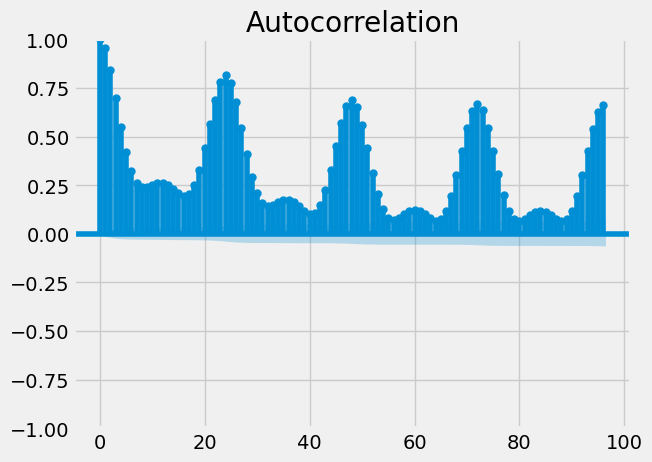

In [244]:
acf_original = plot_acf(df.Value,lags=96) # hourly historical load data (has 24 saesonal length)

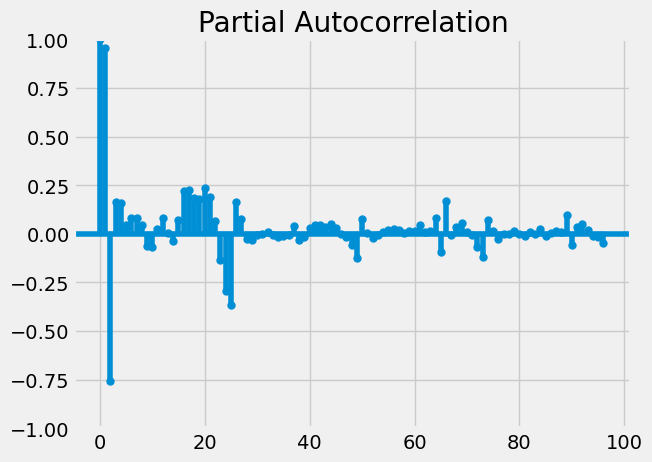

In [245]:
pacf_original = plot_pacf(df.Value,lags=96)

# Fitting SARIMA Model using statsforecast

### AbMax Scale

In [261]:
size = 1034 * 24
train, test = df.Value[0:size], df.Value[size:]

train_max_abs = train.abs().max()

train_scaled =  train / train_max_abs
test_scaled = test / train_max_abs

print(train.shape)
print(train_scaled.shape)

(24816,)
(24816,)


In [262]:
train_sarima = train_scaled.copy()
train_sarima = train_sarima.reset_index()
test_sarima = test_scaled.copy()
test_sarima = test_sarima.reset_index()

# The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:
train_sarima.rename(columns = {'DateUTC':'ds','Value':'y'}, inplace = True) 
train_sarima['unique_id'] = 1.0
test_sarima.rename(columns = {'DateUTC':'ds','Value':'y'}, inplace = True) 
test_sarima['unique_id'] = 1.0

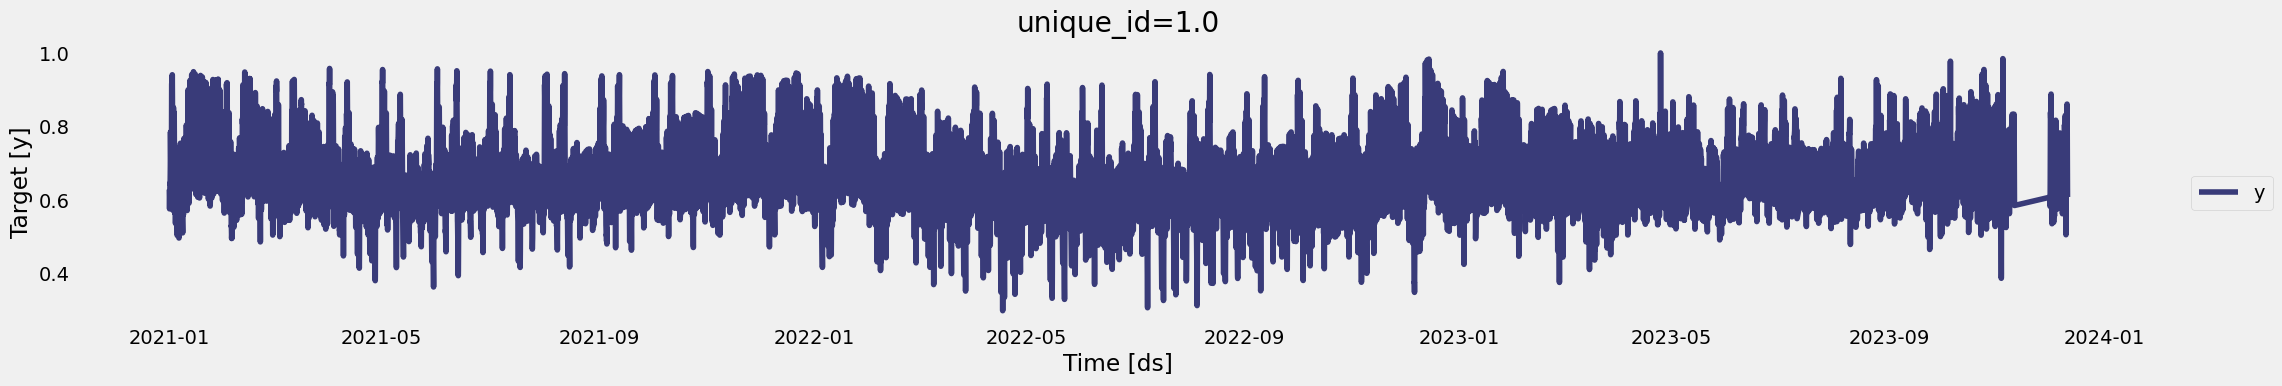

In [263]:
from statsforecast import StatsForecast
StatsForecast.plot(train_sarima, engine="matplotlib")

### Using AutoArima to find best parameters

In [264]:
# https://nixtlaverse.nixtla.io/statsforecast/docs/models/arima.html

In [265]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# using AutoARIMA function to select the best parameters for SARIMA model
sf = StatsForecast(
    models = [AutoARIMA(season_length = 24)],
    freq = 'H'
)
 
sf.fit(train_sarima)

StatsForecast(models=[AutoARIMA])

In [266]:
from statsforecast.arima import arima_string
arima_string(sf.fitted_[0,0].model_)

'ARIMA(3,0,2)(2,1,0)[24]                   '

# Fitting SARIMA model using best parameters

### Forecasting

In [268]:
from statsforecast.models import ARIMA
pred_sarima = []
mape_sarima = []
for d in tqdm(range(len(test_scaled)//24)): 
    # Forecast the next 24 hours' consumption
    model_sarima=ARIMA(order=(3, 0, 2), seasonal_order=(2, 1, 0),season_length=24) 
    model_sarima.fit(y=train_scaled.to_numpy())
    
    forecast = model_sarima.predict(h=24)
   
    pred_sarima.extend(forecast['mean'])
    
   
    test_mape_sarima = mean_absolute_percentage_error(test_scaled.to_numpy()[d*24:d*24+24], forecast['mean'])

    mape_sarima.append(test_mape_sarima)
    
    # Update the training set by concatenating the actual values for the next 24 hours
    train_scaled = pd.concat([train_scaled, test_scaled[d*24:d*24+24]])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [8:16:16<00:00, 488.13s/it]


In [269]:
np.mean(mape_sarima)

0.07415719970963916

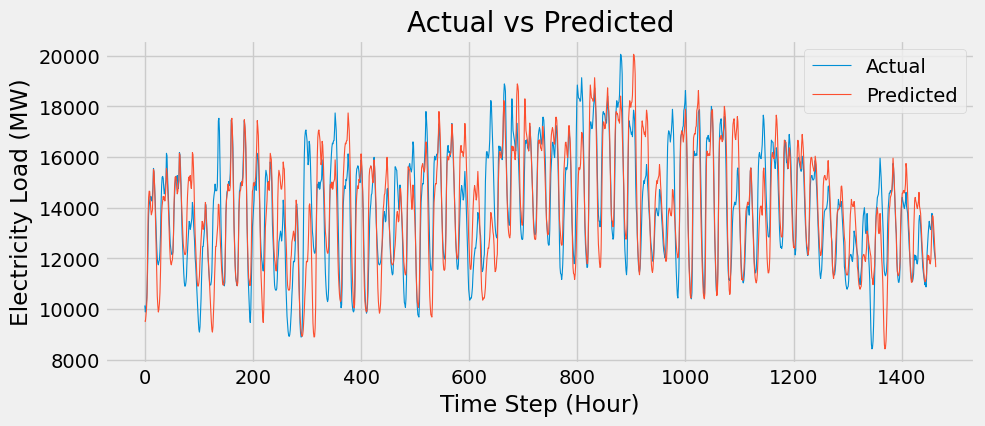

In [1112]:
actual_values_sarima = np.array(test_scaled.values)
predicted_values_sarima = np.array(pred_sarima)

plt.figure(figsize=(10, 4))
plt.plot(actual_values_sarima*train_max_abs, label='Actual',linewidth=0.8)
plt.plot(predicted_values_sarima*train_max_abs, label='Predicted',linewidth=0.8)

plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("SARIMA.pdf", bbox_inches = 'tight')
plt.show()

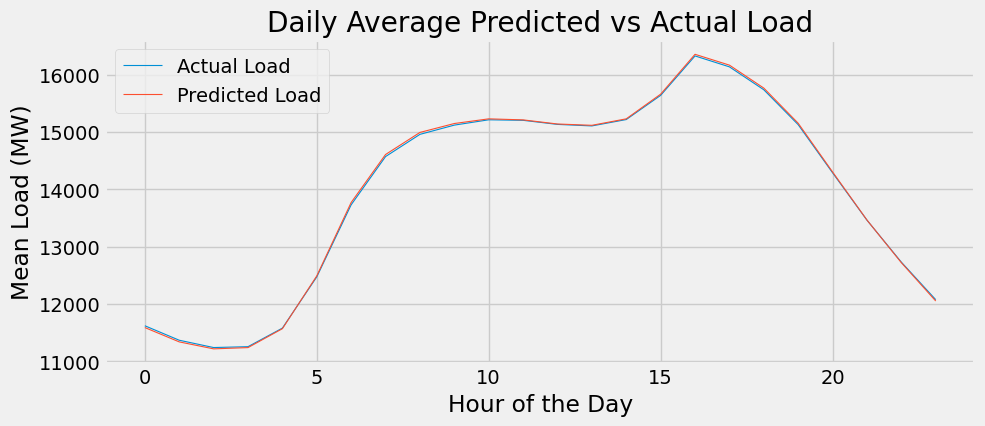

In [1263]:
# Reshape the predicted values to have daily values
daily_predicted_values_sarima = np.reshape(predicted_values_sarima*train_max_abs, (-1, 24))

# Reshape the actual values to have daily values
daily_actual_values_sarima = np.reshape(actual_values_sarima*train_max_abs, (-1, 24))

# Calculate the mean for each hour
predicted_daily_mean_values_sarima = np.mean(daily_predicted_values_sarima, axis=0)
actual_daily_mean_values_sarima = np.mean(daily_actual_values_sarima, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_sarima, label='Actual Load', linewidth=0.8)  
plt.plot(predicted_daily_mean_values_sarima, label='Predicted Load', linewidth=0.8)  

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("SARIMA_daily_average_predicted_vs_actual_load.pdf", bbox_inches='tight')
plt.show()

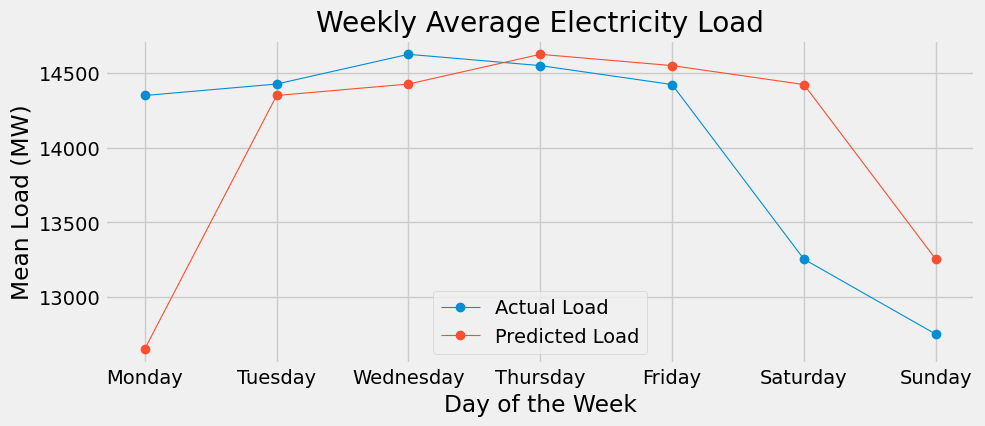

In [1404]:
# Reshape the actual values to have daily values
hourly_actual_values_sarima = np.reshape(actual_values_sarima*train_max_abs, (-1,24))
hourly_predicted_values_sarima = np.reshape(predicted_values_sarima*train_max_abs, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_sarima = np.mean(hourly_actual_values_sarima, axis=1)
daily_predicted_mean_values_sarima = np.mean(hourly_predicted_values_sarima, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_sarima = daily_actual_mean_values_sarima[5:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_sarima = daily_predicted_mean_values_sarima[5:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_sarima, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_sarima, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("SARIMA_Weekly Average Electricity Load.pdf", bbox_inches='tight')
# Show plot
plt.show()

# Linear Regression, XGBoost, LSTM

## Making new dataframe with historical load feature for univariate models

In [250]:
D = 1095
T = 24

X_load_his = np.zeros(((D-3)*T, 72))
for d in range(3,D):
  for t in range(T):
    X_load_his[(d-3)*24+t,:72] = dataframe["Value"].iloc[(d-3)*24:d*24].to_numpy() # 3 days, [96:168]
    #X_load_his[(d-7)*24+t,72:] = dataframe["Value"].iloc[(d-7)*24:(d-6)*24].to_numpy() # one week ago

      
y_target_his = np.zeros(((D-3)*T,))  
for d in range(3,D):
    for t in range(T):
        y_target_his[(d-3)*24+t] = dataframe["Value"].iloc[d*24+t]

In [251]:
print( X_load_his.shape)
print(y_target_his.shape)

(26208, 72)
(26208,)


## Making new dataframe with 244 input features for multivariate models

In [252]:
D = 1095
T = 24

X_load = np.zeros(((D-3)*T, 72))
for d in range(3,D):
  for t in range(T):
    X_load[(d-3)*24+t,:72] = dataframe["Value"].iloc[(d-3)*24:d*24].to_numpy() # 3 days, [96:168]
    #X_load[(d-7)*24+t,72:] = dataframe["Value"].iloc[(d-7)*24:(d-6)*24].to_numpy() # one week ago


wea_list = ['WindSpeed','Temperature','PrecipitationAmount','PrecipitationDuration','GlobalRadiation','AirPressure','CloudCover']
X_wea = np.zeros(((D-3)*T, 7*24))
for d in range(3,D):
    for t in range(T):
        for f in range(len(wea_list)):
            X_wea[(d-3)*24+t,f*24:(f+1)*24] = dataframe[wea_list[f]].iloc[(d-1)*24:d*24].to_numpy()


cal_list = ['Hour','DayofWeek','Month','isHoliday?']
X_cal = np.zeros(((D-3)*T, 4))
for d in range(3,D):
    for t in range(T):
        for f in range(len(cal_list)):
            X_cal[(d-3)*24+t,f] = dataframe[cal_list[f]].iloc[d*24+t]

        
y_target = np.zeros(((D-3)*T,))  
for d in range(3,D):
    for t in range(T):
        y_target[(d-3)*24+t] = dataframe["Value"].iloc[d*24+t]

X_input = np.concatenate((X_load,X_wea,X_cal), axis = 1)

In [253]:
print(y_target.shape)
print(X_input.shape)

(26208,)
(26208, 244)


# Training / Validation / Test dataset Split

In [254]:
# univariate 
X_train_load = X_load_his[:910*24]
X_val_load = X_load_his[911*24:1034*24]
X_test_load = X_load_his[1034*24:]
y_train_load = y_target_his[:910*24]
y_val_load = y_target_his[911*24:1034*24]
y_test_load = y_target_his[1034*24:]

In [1351]:
y_test_load.shape

(1392,)

In [256]:
# multivariate
X_train = X_input[:910*24]
X_val = X_input[910*24:1034*24]
X_test = X_input[1034*24:]
y_train = y_target[:910*24]
y_val = y_target[910*24:1034*24]
y_test = y_target[1034*24:]

In [257]:
y_test.shape

(1392,)

In [258]:
print(len(X_train))
print(len(X_val))
print(len(X_test))
print('=================')
print(len(y_train))
print(len(y_val))
print(len(y_test))

21840
2976
1392
21840
2976
1392


# Data Split Plot

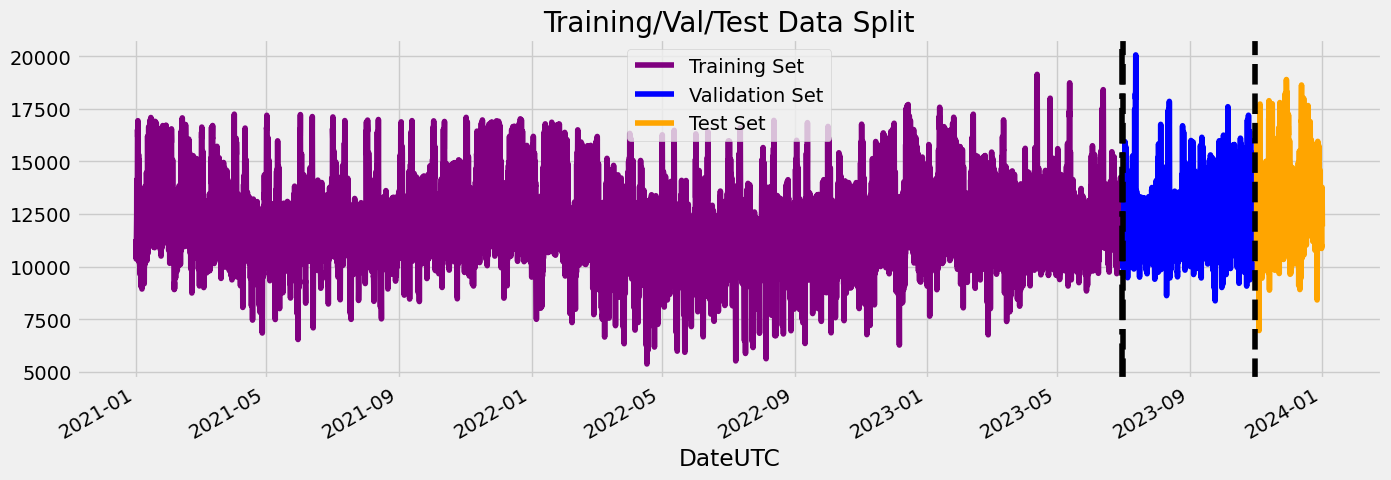

In [1555]:
train = df.loc[his_df.index <= '06-30-2023']
val = df.loc[(his_df.index >= '07-01-2023') & (his_df.index <= '10-31-2023')]
test = df.loc[his_df.index >= '11-01-2023']
fig, ax = plt.subplots(figsize=(15, 5))
train.Value.plot(ax=ax, label='Training Set', color='purple')
val.Value.plot(ax=ax, label='Validation Set', color='blue')
test.Value.plot(ax=ax, label='Test Set', color='orange')
ax.axvline('07-01-2023', color='black', ls='--')
ax.axvline('10-31-2023', color='black', ls='--')
ax.axvline('06-30-2023', color='black', ls='-.')  # Added for clarity
ax.legend()
ax.set_title('Training/Val/Test Data Split')
plt.savefig("datasplit", bbox_inches = 'tight')
plt.show()

# Normalization & One-hot Encoding

In [59]:
# univariate
#=====================================================================
scaler = MinMaxScaler()

X_train_load_norm = scaler.fit_transform(X_train_load)
X_val_load_norm = scaler.transform(X_val_load)
X_test_load_norm = scaler.transform(X_test_load)

print(X_train_load_norm.shape)

(21840, 72)


In [60]:
# univariate y_label normalization
#======================================================================
y_load_min = y_train_load.min()
y_load_max = y_train_load.max()
y_train_load_norm = (y_train_load-y_load_min)/(y_load_max-y_load_min )
y_val_load_norm = (y_val_load-y_load_min)/(y_load_max-y_load_min )
y_test_load_norm = (y_test_load-y_load_min)/(y_load_max-y_load_min )

In [62]:
# multivariate
#==================================================================================
# Normalizing
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train[:, 0:240])
X_val_normalized = scaler.transform(X_val[:,0:240])
X_test_normalized = scaler.transform(X_test[:, 0:240])

print(X_train_normalized.shape)

# Encoding
encoder = OneHotEncoder(sparse_output=False)

encoded_columns_train = encoder.fit_transform(X_train[:, 240:244])
encoded_columns_val = encoder.transform(X_val[:, 240:244])
encoded_columns_test = encoder.transform(X_test[:, 240:244])

print(encoded_columns_train.shape)  

# Concatenate normalized and encoded columns
X_train_processed = np.hstack((X_train_normalized, encoded_columns_train))
X_val_processed = np.hstack((X_val_normalized, encoded_columns_val))
X_test_processed = np.hstack((X_test_normalized, encoded_columns_test))

print(X_train_processed.shape)  # Output: (21840, 244)

(21840, 240)
(21840, 45)
(21840, 285)


In [63]:
# multivariate y_label normalization
#======================================================================
y_min = y_train.min()
y_max = y_train.max()
y_train_norm = (y_train-y_min)/(y_max-y_min )
y_val_norm = (y_val-y_min)/(y_max-y_min )
y_test_norm = (y_test-y_min)/(y_max-y_min )

In [64]:
y_train_norm.shape

(21840,)

# Linear Regression

In [1114]:
#univariate
reg_load = LinearRegression().fit(X_train_load_norm, y_train_load_norm)
p_train_load_lr = reg_load.predict(X_train_load_norm)
p_test_load_lr = reg_load.predict(X_test_load_norm)

MAPE_train_load_lr = mean_absolute_percentage_error(y_train_load_norm*(y_load_max-y_load_min)+y_load_min, p_train_load_lr*(y_load_max-y_load_min)+y_load_min)
MAPE_test_load_lr = mean_absolute_percentage_error(y_test_load_norm*(y_load_max-y_load_min)+y_load_min, p_test_load_lr*(y_load_max-y_load_min)+y_load_min)

print("Train MAPE: {}\nTest MAPE: {}".format(MAPE_train_load_lr,MAPE_test_load_lr)) 

Train MAPE: 0.1079423656604339
Test MAPE: 0.1409706026156155


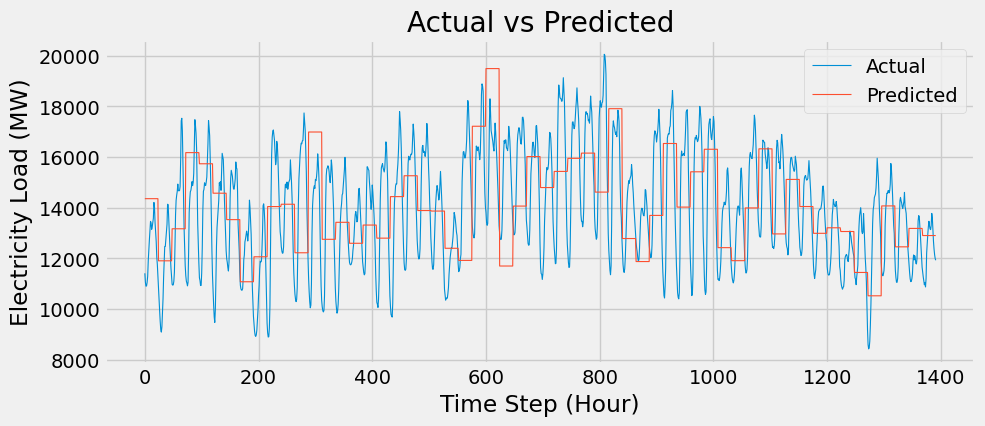

In [1115]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_load_norm*(y_load_max-y_load_min)+y_load_min, label='Actual',linewidth=0.8)
plt.plot(p_test_load_lr*(y_load_max-y_load_min)+y_load_min, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lr_load.pdf", bbox_inches = 'tight')
plt.show() 

In [1116]:
# Multivariate
reg = LinearRegression().fit(X_train_processed, y_train_norm)
p_train_lr = reg.predict(X_train_processed)
p_test_lr = reg.predict(X_test_processed)

MAPE_train_lr = mean_absolute_percentage_error(y_train_norm*(y_max-y_min)+y_min, p_train_lr*(y_max-y_min)+y_min)
MAPE_test_lr = mean_absolute_percentage_error(y_test_norm*(y_max-y_min)+y_min, p_test_lr*(y_max-y_min)+y_min)

print("Train MAPE: {}\nTest MAPE: {}".format(MAPE_train_lr,MAPE_test_lr) )

Train MAPE: 0.073256958110189
Test MAPE: 0.10927327528521481


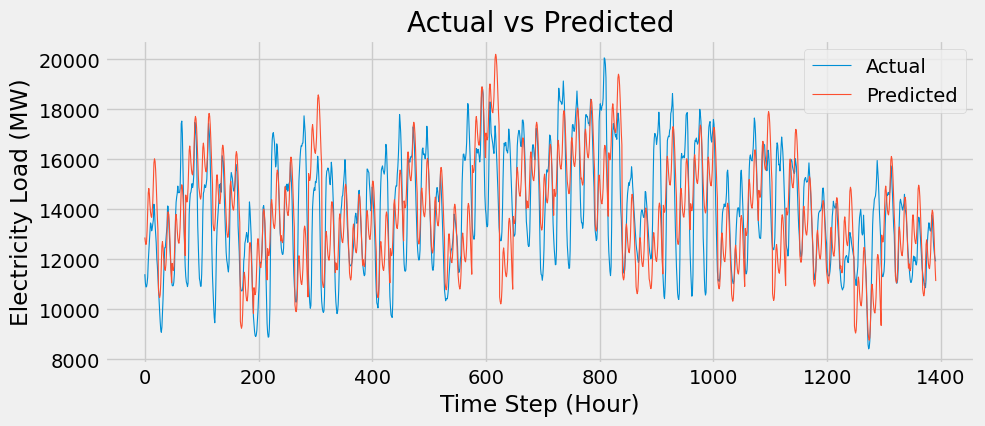

In [1117]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_norm*(y_max-y_min)+y_min, label='Actual',linewidth=0.8)
plt.plot(p_test_lr*(y_max-y_min)+y_min, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lr_multi.pdf", bbox_inches = 'tight')
plt.show() 

In [91]:
model_params = reg.get_params()
print(model_params)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


# Hyperparameter Tuning - Linear Regression

In [1467]:
# univariate
#========================================================================
alpha_values = [0.001,0.003,0.01,0.03, 0.1,0.3,1,3,10,30,100]

best_alpha_load = None
best_mape_load = float('inf')

# Iterate over each alpha value
for alpha in alpha_values:
    # Initialize Ridge Regression model with the current alpha value
    ridge_load = Ridge(alpha=alpha)
    
    # Train Ridge Regression model on the training set
    ridge_load.fit(X_train_load_norm, y_train_load_norm)
    
    # Predict on the validation set
    p_val_load_lr_tuned = ridge_load.predict(X_val_load_norm)
    
    # Calculate mape on the validation set
    val_mape_load_lr_tuned = mean_absolute_percentage_error(y_val_load_norm*(y_load_max-y_load_min)+y_load_min, p_val_load_lr_tuned*(y_load_max-y_load_min)+y_load_min)
    
    # If the current model has a lower validation MSE, update the best alpha and MSE
    if val_mape_load_lr_tuned < best_mape_load:
        best_alpha_load = alpha
        best_mape_load = val_mape_load_lr_tuned
        print(best_mape_load)
        
start_time = time.time()
# Train the final Ridge Regression model using the best alpha
final_ridge_load = Ridge(alpha=best_alpha_load)
final_ridge_load.fit(X_train_load_norm, y_train_load_norm)

# Predict on the test set
p_test_load_lr_tuned = final_ridge_load.predict(X_test_load_norm)
end_time = time.time()
computational_time = end_time - start_time

# Calculate mean squared error on the test set
test_mape_load_lr_tuned = mean_absolute_percentage_error(y_test_load_norm*(y_load_max-y_load_min)+y_load_min, p_test_load_lr_tuned*(y_load_max-y_load_min)+y_load_min)

print("Best Alpha:", best_alpha_load)
print("Validation MAPE:", best_mape_load)
print("Test MAPE:", test_mape_load_lr_tuned)
print('Computational Time:', computational_time)

0.10686202846826066
0.10685083524228554
0.10681200093605626
0.10670451693496864
0.10636791429310788
0.10559467446462087
0.1039755637855922
0.10202934647946808
0.10043218571364841
0.10019817102988508
0.09982431541218954
Best Alpha: 100
Validation MAPE: 0.09982431541218954
Test MAPE: 0.12762290717349764
Computational Time: 0.01428985595703125


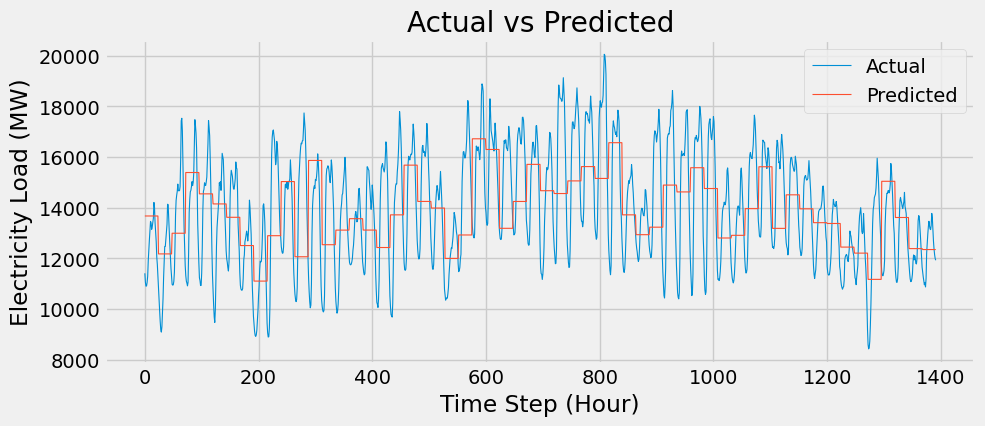

In [1460]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_load_norm*(y_load_max-y_load_min)+y_load_min, label='Actual',linewidth=0.8)
plt.plot(p_test_load_lr_tuned*(y_load_max-y_load_min)+y_load_min, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lr_load_tuned.pdf", bbox_inches = 'tight')
plt.show() 

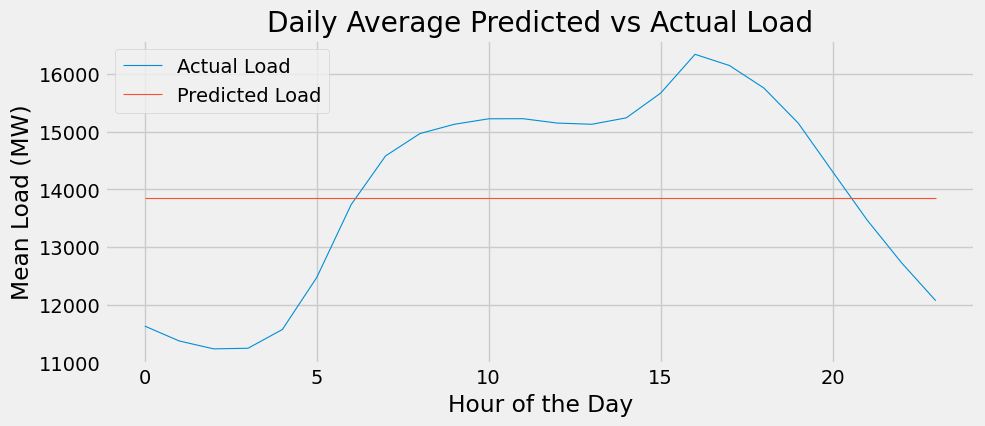

In [1318]:
# Reshape the predicted values to have daily values
daily_predicted_values_lr_load = np.reshape(p_test_load_lr_tuned*(y_load_max-y_load_min)+y_load_min, (-1, 24))
daily_actual_values_lr_load = np.reshape(y_test_load_norm*(y_load_max-y_load_min)+y_load_min, (-1, 24))

# Calculate the mean for each hour
predicted_daily_mean_values_lr_load = np.mean(daily_predicted_values_lr_load, axis=0)
actual_daily_mean_values_lr_load = np.mean(daily_actual_values_lr_load, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_lr_load, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_lr_load, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("LR_daily_average_predicted_vs_actual_load.pdf", bbox_inches='tight')
plt.show()

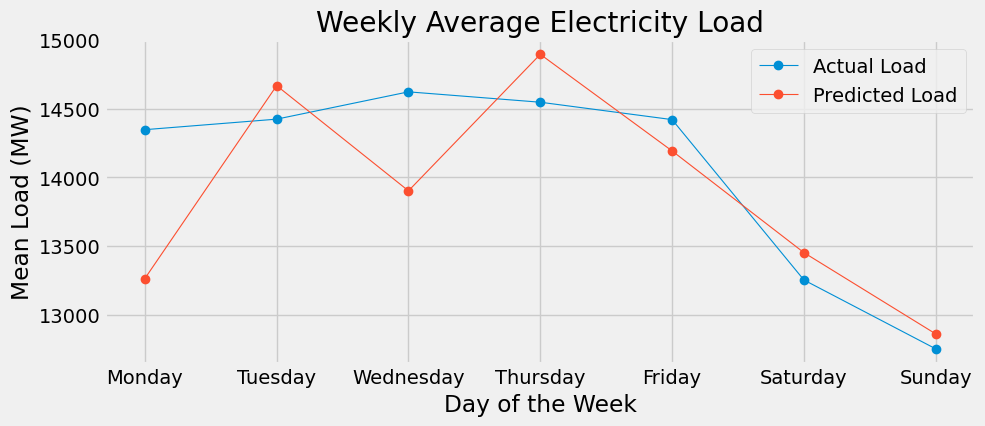

In [1319]:
# Reshape the actual values to have daily values
hourly_actual_values_lr_load = np.reshape(y_test_load_norm*(y_load_max-y_load_min)+y_load_min, (-1,24))
hourly_predicted_values_lr_load = np.reshape(p_test_load_lr_tuned*(y_load_max-y_load_min)+y_load_min, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_lr_load = np.mean(hourly_actual_values_lr_load, axis=1)
daily_predicted_mean_values_lr_load = np.mean(hourly_predicted_values_lr_load, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_lr_load = daily_actual_mean_values_lr_load[2:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_lr_load = daily_predicted_mean_values_lr_load[2:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_lr_load, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_lr_load, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("LR_LOAD_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

In [1129]:
# multivariate
#=======================================================================
# Define a range of alpha values to search
alpha_values = [0.001,0.003,0.01,0.03, 0.1,0.3,1,3,10,30,100]

best_alpha = None
best_mape = float('inf')

# Iterate over each alpha value
for alpha in alpha_values:
    # Initialize Ridge Regression model with the current alpha value
    ridge = Ridge(alpha=alpha)
    
    # Train Ridge Regression model on the training set
    ridge.fit(X_train_processed, y_train_norm)
    
    # Predict on the validation set
    p_val_lr_tuned = ridge.predict(X_val_processed)
    
    # Calculate mape on the validation set
    val_mape_lr_tuned = mean_absolute_percentage_error(y_val_norm*(y_max-y_min)+y_min, p_val_lr_tuned*(y_max-y_min)+y_min)
    
    # If the current model has a lower validation MSE, update the best alpha and MSE
    if val_mape_lr_tuned < best_mape:
        best_alpha = alpha
        best_mape = val_mape_lr_tuned
        print(best_mape)
        
start_time = time.time()
# Train the final Ridge Regression model using the best alpha
final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train_processed, y_train_norm)

# Predict on the test set
p_test_lr_tuned = final_ridge.predict(X_test_processed)
end_time = time.time()
computational_time = end_time - start_time

# Calculate mean squared error on the test set
test_mape_lr_tuned = mean_absolute_percentage_error(y_test_norm*(y_max-y_min)+y_min, p_test_lr_tuned*(y_max-y_min)+y_min)

print("Best Alpha:", best_alpha)
print("Validation MAPE:", best_mape)
print("Test MAPE:", test_mape_lr_tuned)
print('Computational Time:', computational_time)

0.07952370377941552
0.07944882106148175
0.07923221611514676
0.07883652537222757
0.07815817490769522
0.07714231167186081
0.0751530873256447
0.07263405600232371
0.07019314276439959
0.06888908216789603
0.06764614417371062
Best Alpha: 100
Validation MAPE: 0.06764614417371062
Test MAPE: 0.09311301458883721
Computational Time: 0.036195993423461914


In [110]:
def predict_ridge(X):
    return final_ridge.predict(X)

explainer_lr = shap.KernelExplainer(predict_ridge, X_train_processed[:100,:])

# Compute SHAP values for the test set
shap_values_lr = explainer_lr.shap_values(X_test_processed)

  0%|          | 0/1392 [00:00<?, ?it/s]

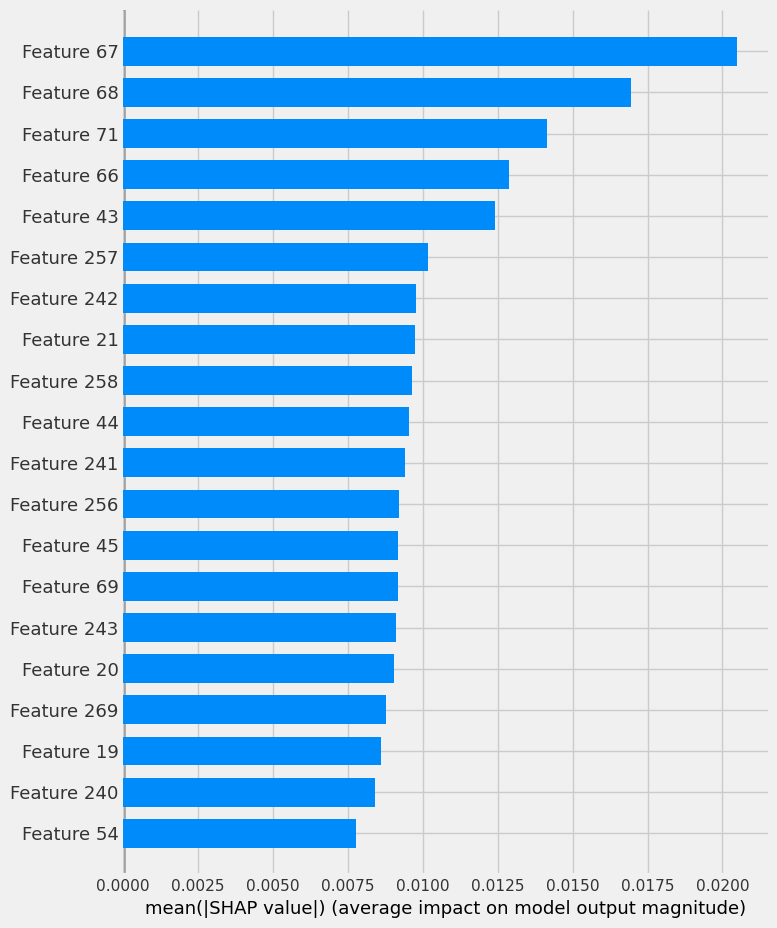

In [113]:
shap.summary_plot(shap_values_lr,X_test_processed, plot_type='bar')

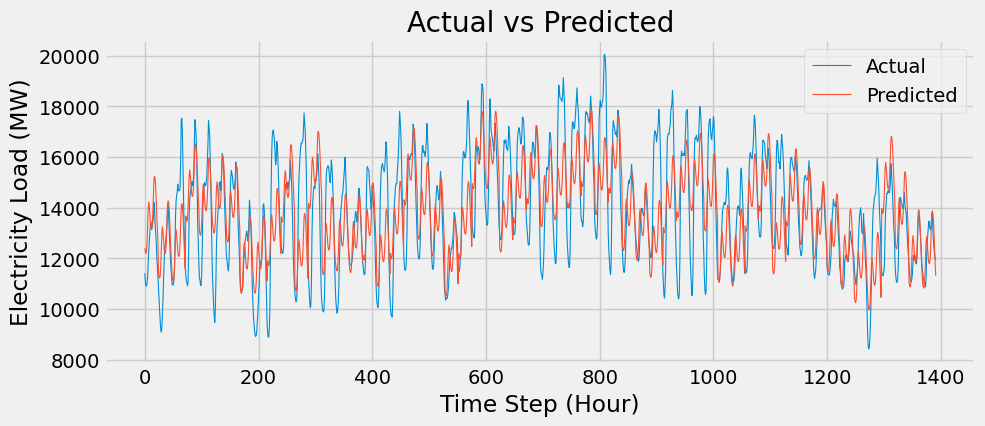

In [1320]:
# Plot the actual values and predicted values
#week = 0

plt.figure(figsize=(10, 4))
plt.plot((y_test_norm*(y_max-y_min)+y_min), label='Actual',linewidth=0.8)
plt.plot((p_test_lr_tuned*(y_max-y_min)+y_min), label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lr_multi_tuned.pdf", bbox_inches = 'tight')
plt.show() 

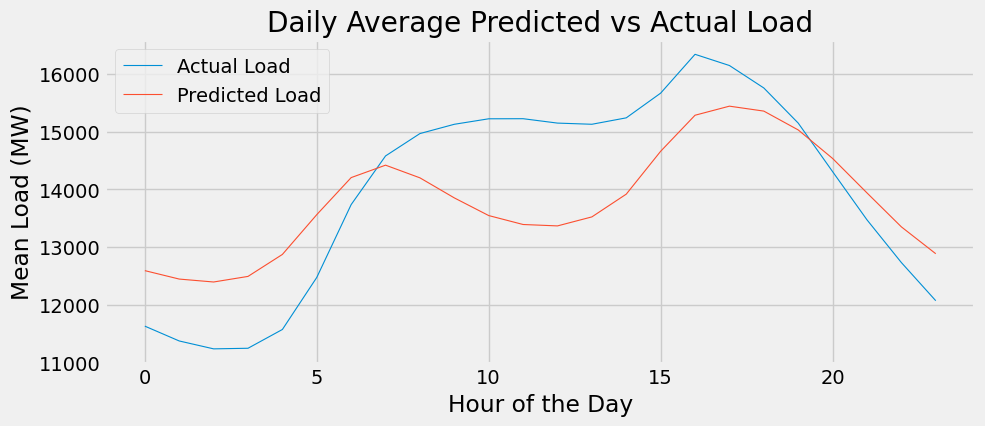

In [1321]:
# Reshape the predicted values to have daily values
daily_predicted_values_lr = np.reshape(p_test_lr_tuned*(y_max-y_min)+y_min, (-1, 24))

# Reshape the actual values to have daily values
daily_actual_values_lr = np.reshape(y_test_norm*(y_max-y_min)+y_min, (-1, 24))

# Calculate the mean for each hour
predicted_daily_mean_values_lr = np.mean(daily_predicted_values_lr, axis=0)
actual_daily_mean_values_lr = np.mean(daily_actual_values_lr, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_lr, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_lr, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("LR_daily_average_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

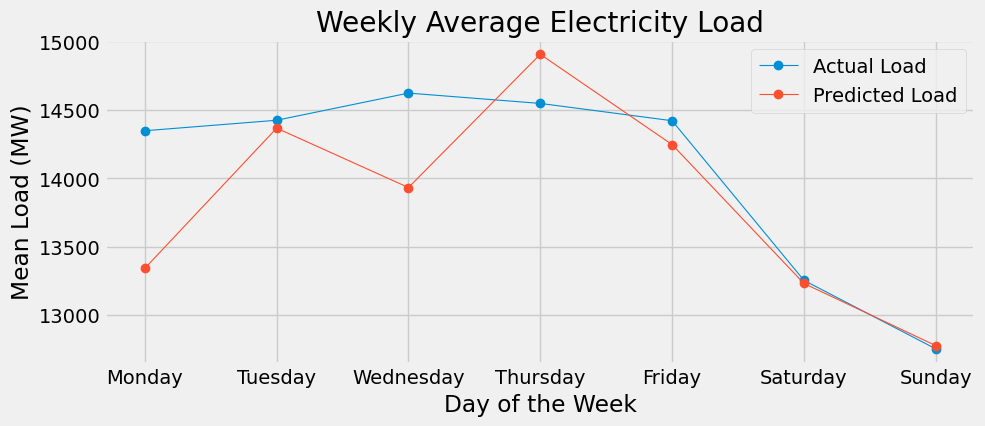

In [1322]:
# Reshape the actual values to have daily values
hourly_actual_values_lr_multi = np.reshape(y_test_norm*(y_max-y_min)+y_min, (-1,24))
hourly_predicted_values_lr_multi = np.reshape(p_test_lr_tuned*(y_max-y_min)+y_min, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_lr_multi = np.mean(hourly_actual_values_lr_multi, axis=1)
daily_predicted_mean_values_lr_multi = np.mean(hourly_predicted_values_lr_multi, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_lr_multi = daily_actual_mean_values_lr_multi[2:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_lr_multi = daily_predicted_mean_values_lr_multi[2:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_lr_multi, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_lr_multi, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("LR_MULTI_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

# XGBoost Model

## Univariate XGBoost

In [1201]:
#univariate
#========================================================

np.random.seed(42)
random.seed(42)
xgb_load = xgb.XGBRegressor(booster='gbtree',
                            base_score = 0.5,
                            n_estimators=200,random_state = 42)
xgb_load.fit(X_train_load, y_train_load,
             eval_set=[(X_train_load, y_train_load), (X_val_load, y_val_load)],
             verbose=100)

[0]	validation_0-rmse:8472.65296	validation_1-rmse:8921.04086
[100]	validation_0-rmse:1388.97124	validation_1-rmse:1463.61201
[199]	validation_0-rmse:1388.96437	validation_1-rmse:1463.49504


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [1200]:
p_train_load_xgb = xgb_load.predict(X_train_load)
p_test_load_xgb = xgb_load.predict(X_test_load)
MAPE_train_load_xgb = mean_absolute_percentage_error(y_train_load, p_train_load_xgb)
MAPE_test_load_xgb = mean_absolute_percentage_error(y_test_load, p_test_load_xgb)
print(MAPE_train_load_xgb)
print(MAPE_test_load_xgb )

0.10049811896594202
0.1316993592375388


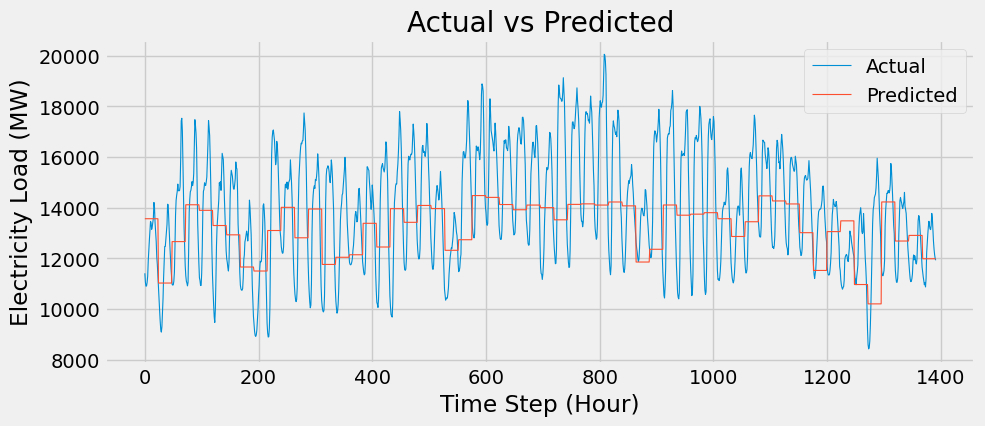

In [900]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_load, label='Actual',linewidth=0.8)
plt.plot(p_test_load_xgb, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("xgb_load.pdf", bbox_inches = 'tight')
plt.show()

## Multivariate XGBoost

In [903]:
# multivariate
#===================================================
np.random.seed(42)
random.seed(42)
reg_multi = xgb.XGBRegressor(booster='gbtree',
                            base_score=0.5,    
                       n_estimators=200,random_state = 42)
reg_multi.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)  

[0]	validation_0-rmse:8439.29623	validation_1-rmse:8884.53139
[100]	validation_0-rmse:282.35144	validation_1-rmse:958.20055
[199]	validation_0-rmse:180.25143	validation_1-rmse:962.61551


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [904]:
p_train_xgb = reg_multi.predict(X_train)
p_test_xgb = reg_multi.predict(X_test)
MAPE_train_xgb = mean_absolute_percentage_error(y_train, p_train_xgb)
MAPE_test_xgb = mean_absolute_percentage_error(y_test, p_test_xgb)
print(MAPE_train_xgb)
print(MAPE_test_xgb)

0.011104039348619048
0.07791423354668801


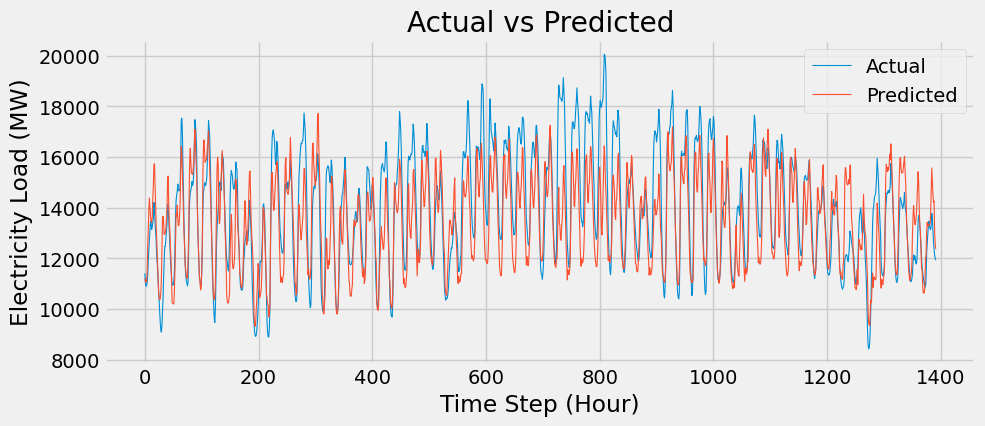

In [905]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual',linewidth=0.8)
plt.plot(p_test_xgb, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("xgb_multi.pdf", bbox_inches = 'tight')
plt.show()

## XGBoost Univariate Hyperparamater Tuning

### https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [1001]:
space = {
    'max_depth': hp.quniform("max_depth", 2, 5, 1),  
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.05),
    'n_estimators': hp.quniform('n_estimators', 600, 1000, 100) 
}



def objective(space):
    np.random.seed(42)
    random.seed(42)
    clf_load = xgb.XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth= int(space['max_depth']),
        learning_rate = space['learning_rate'],
        eval_metric="mae",
        early_stopping_rounds=20,
        random_state = 42
    )
    
    evaluation = [(X_train_load, y_train_load), (X_val_load, y_val_load)]
    
   

    clf_load.fit(
        X_train_load, y_train_load,
        eval_set=evaluation,
         verbose=False
    )
    
    p_val_load_xgb_tuned = clf_load.predict(X_val_load)
    mape_load_xgb_tuned = mean_absolute_percentage_error(y_val_load, p_val_load_xgb_tuned)
    print("MAPE:",  mape_load_xgb_tuned)
    
    return {'loss': -mape_load_xgb_tuned, 'status': STATUS_OK}

In [1002]:
from hyperopt import fmin, tpe, Trials
trials = Trials()

best_hyperparams_load_xgb = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

MAPE:                                                                                                                                                                                                         
0.09930599911656483                                                                                                                                                                                           
MAPE:                                                                                                                                                                                                         
0.09901345500390785                                                                                                                                                                                           
MAPE:                                                                                                                                                                       

In [1003]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams_load_xgb)

The best hyperparameters are :  

{'learning_rate': 0.011071430676049475, 'max_depth': 2.0, 'n_estimators': 600.0}


In [1131]:
np.random.seed(42)
random.seed(42)
start_time = time.time() 
best_hyperparams_load_xgb = {'learning_rate': 0.011071430676049475, 
                             'max_depth': 2, 
                             'n_estimators': 600}


model_load_xgb_tuned = xgb.XGBRegressor(**best_hyperparams_load_xgb, random_state = 42,
                              base_score=0.5, 
                                eval_metric="mae",
                                early_stopping_rounds=20)

evaluation = [(X_train_load, y_train_load), (X_val_load, y_val_load)]
model_load_xgb_tuned.fit(X_train_load, y_train_load,
                eval_set=evaluation,
                verbose=100) 
end_time = time.time()  
computational_time = end_time - start_time 
print('Computational Time:',computational_time)

[0]	validation_0-mae:11720.49245	validation_1-mae:12242.30987
[100]	validation_0-mae:3858.22199	validation_1-mae:4354.64381
[200]	validation_0-mae:1595.84074	validation_1-mae:1862.08757
[300]	validation_0-mae:1295.51150	validation_1-mae:1392.11932
[400]	validation_0-mae:1258.82981	validation_1-mae:1291.14671
[500]	validation_0-mae:1248.15629	validation_1-mae:1258.83454
[599]	validation_0-mae:1241.48737	validation_1-mae:1246.84380
Computational Time: 1.1590170860290527


In [1132]:
p_train_load_xgb_tuned = model_load_xgb_tuned.predict(X_train_load)
p_test_load_xgb_tuned = model_load_xgb_tuned.predict(X_test_load)
MAPE_train_load_xgb_tuned = mean_absolute_percentage_error(y_train_load, p_train_load_xgb_tuned)
MAPE_test_load_xgb_tuned = mean_absolute_percentage_error(y_test_load, p_test_load_xgb_tuned)
print(MAPE_train_load_xgb_tuned)
print(MAPE_test_load_xgb_tuned )

0.1074045131930564
0.12947674984941468


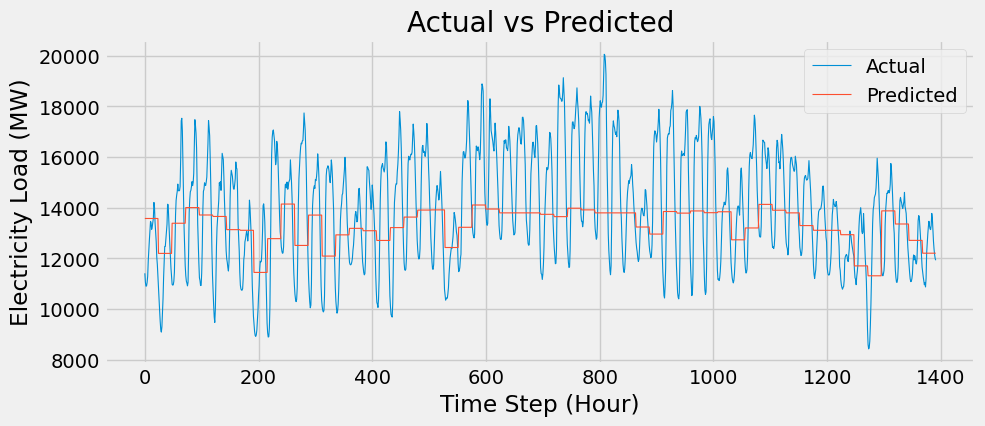

In [1323]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_load, label='Actual',linewidth=0.8)
plt.plot(p_test_load_xgb_tuned, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("xgb_load_tuned.pdf", bbox_inches = 'tight')
plt.show()

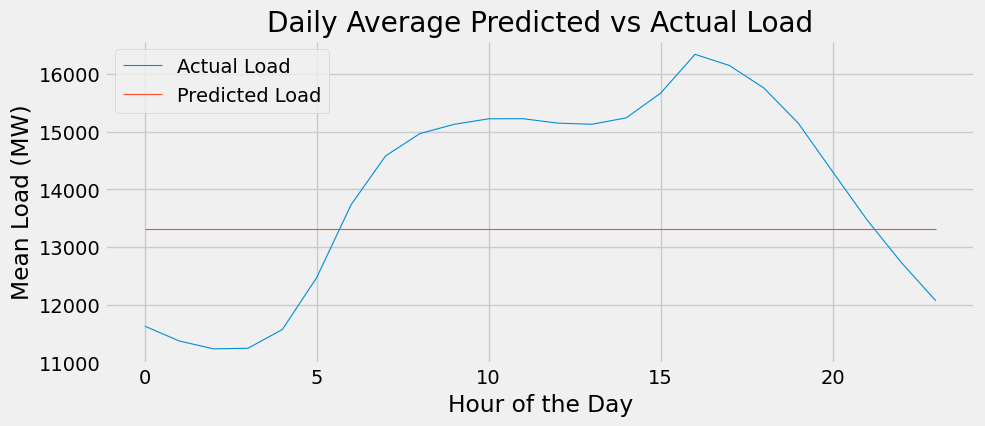

In [1324]:
# Reshape the predicted values to have daily values
daily_predicted_values_xgb_load = np.reshape(p_test_load_xgb_tuned, (-1, 24))

# Reshape the actual values to have daily values
daily_actual_values_xgb_load = np.reshape(y_test_load, (-1, 24))

# Calculate the mean for each hour
predicted_daily_mean_values_xgb_load = np.mean(daily_predicted_values_xgb_load, axis=0)
actual_daily_mean_values_xgb_load = np.mean(daily_actual_values_xgb_load, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_xgb_load, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_xgb_load, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("XGB_daily_average_predicted_vs_actual_load.pdf", bbox_inches='tight')
plt.show()

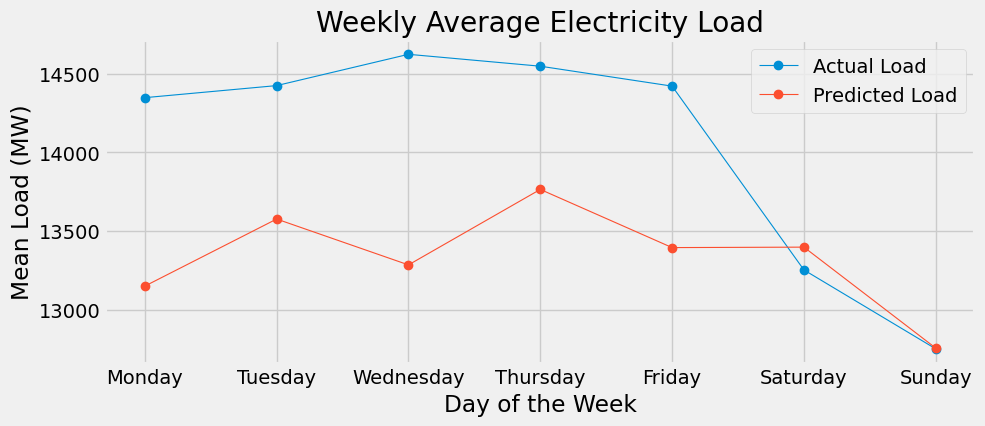

In [1325]:
# Reshape the actual values to have daily values
hourly_actual_values_xgb_load = np.reshape(y_test_load, (-1,24))
hourly_predicted_values_xgb_load = np.reshape(p_test_load_xgb_tuned, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_xgb_load = np.mean(hourly_actual_values_xgb_load, axis=1)
daily_predicted_mean_values_xgb_load = np.mean(hourly_predicted_values_xgb_load, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_xgb_load = daily_actual_mean_values_xgb_load[2:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_xgb_load = daily_predicted_mean_values_xgb_load[2:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_xgb_load, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_xgb_load, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("XGB_LOAD_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

## XGBoost Multivariate Hyperparameter Tuning 

In [989]:
space = {
    'max_depth': hp.quniform("max_depth", 3, 5, 1),  
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'n_estimators': hp.quniform('n_estimators', 1000, 1200, 100) 
}


In [990]:
#Define objective function 
from hyperopt import STATUS_OK

def objective(space): 
    np.random.seed(42)
    random.seed(42)
    clf = xgb.XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate = space['learning_rate'],
        eval_metric="mae",
        early_stopping_rounds=100,
        random_state = 42
    )
    
    evaluation = [(X_train, y_train), (X_val, y_val)]
    
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
         verbose=False)
    
    p_val_xgb_tuned = clf.predict(X_val)
    mape_xgb_tuned = mean_absolute_percentage_error(y_val, p_val_xgb_tuned)
    print("MAPE:", mape_xgb_tuned)
    
    return {'loss': -mape_xgb_tuned, 'status': STATUS_OK}

In [991]:
#Optimization algorithm
from hyperopt import fmin, tpe, Trials
trials = Trials()   

best_hyperparams_xgb = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

MAPE:                                                                                                                                                                                                         
0.04786254013215192                                                                                                                                                                                           
MAPE:                                                                                                                                                                                                         
0.04987946773845869                                                                                                                                                                                           
MAPE:                                                                                                                                                                       

In [992]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams_xgb)

The best hyperparameters are :  

{'learning_rate': 0.010035653242186441, 'max_depth': 3.0, 'n_estimators': 1000.0}


In [1133]:
start_time = time.time() 
best_hyperparams_xgb =  {'learning_rate': 0.010035653242186441,
                         'max_depth': 3, 
                         'n_estimators': 1000}





model_xgb_tuned = xgb.XGBRegressor(**best_hyperparams_xgb, random_state=42,
                                booster='gbtree', 
                                eval_metric="mae",early_stopping_rounds=20)

evaluation = [(X_train, y_train), (X_val, y_val)]
model_xgb_tuned.fit(X_train, y_train,
                eval_set=evaluation,
                verbose=100)
end_time = time.time()  
computational_time = end_time - start_time 
print('Computational Time:',computational_time)

[0]	validation_0-mae:1527.54676	validation_1-mae:1371.70063
[100]	validation_0-mae:1024.86275	validation_1-mae:1011.63484
[200]	validation_0-mae:830.71782	validation_1-mae:875.57840
[300]	validation_0-mae:736.69671	validation_1-mae:803.92148
[400]	validation_0-mae:683.66475	validation_1-mae:772.10137
[500]	validation_0-mae:647.49647	validation_1-mae:751.08002
[600]	validation_0-mae:623.15078	validation_1-mae:735.67221
[700]	validation_0-mae:606.19878	validation_1-mae:729.26511
[800]	validation_0-mae:590.77127	validation_1-mae:721.78262
[900]	validation_0-mae:577.81711	validation_1-mae:715.63848
[999]	validation_0-mae:568.09910	validation_1-mae:712.25622
Computational Time: 4.945551156997681


In [1134]:
p_train_xgb_tuned = model_xgb_tuned.predict(X_train,output_margin=True)
p_test_xgb_tuned = model_xgb_tuned.predict(X_test)
MAPE_train_xgb_tuned = mean_absolute_percentage_error(y_train, p_train_xgb_tuned)
MAPE_test_xgb_tuned = mean_absolute_percentage_error(y_test, p_test_xgb_tuned)
print(MAPE_train_xgb_tuned)
print(MAPE_test_xgb_tuned) 

0.049714645527883065
0.07366070677038389


[01:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


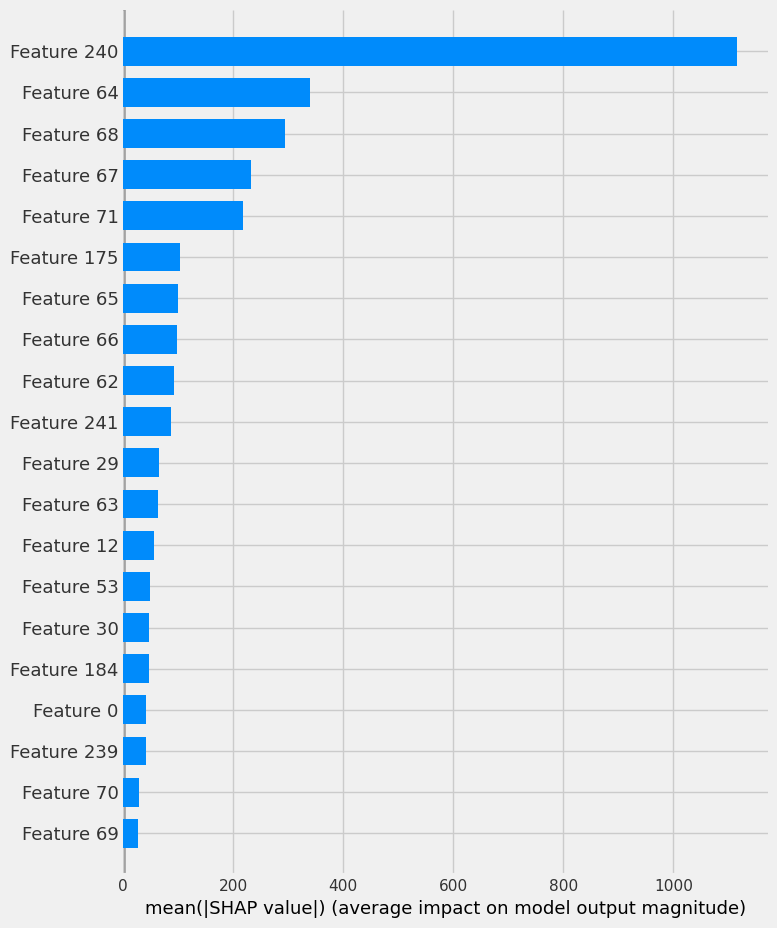

In [998]:
X_sampled = X_train[:100,:]
explainer_xgb = shap.TreeExplainer(model_xgb_tuned)
shap_values_xgb = explainer_xgb.shap_values(X_sampled)
shap.summary_plot(shap_values_xgb,X_train, plot_type="bar")

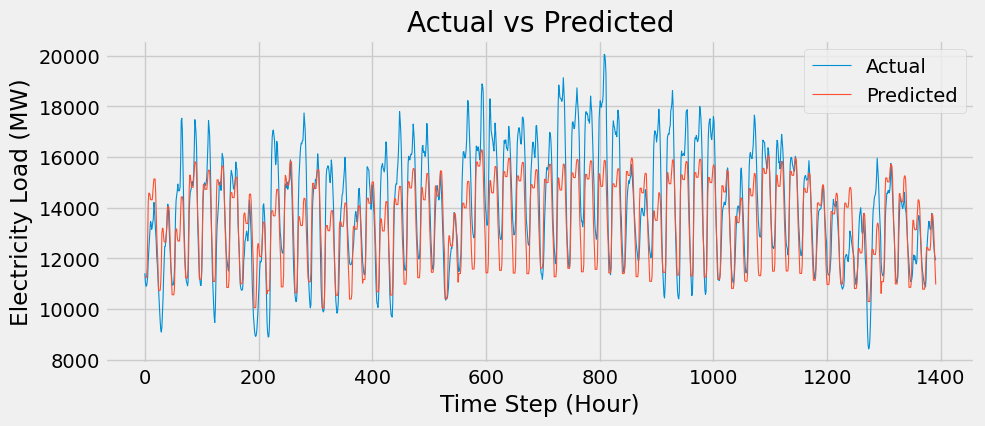

In [1326]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual',linewidth=0.8)
plt.plot(p_test_xgb_tuned, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("xgb_multi_tuned.pdf", bbox_inches = 'tight')
plt.show() 

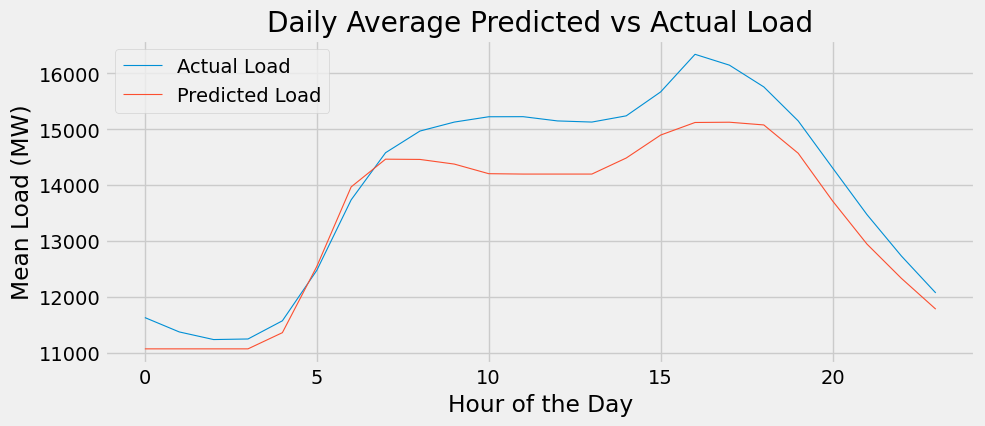

In [1327]:
# Reshape the predicted values to have daily values
daily_predicted_values_xgb = np.reshape(p_test_xgb_tuned, (-1, 24))

# Reshape the actual values to have daily values
daily_actual_values_xgb = np.reshape(y_test, (-1, 24))

# Calculate the mean for each hour
predicted_daily_mean_values_xgb = np.mean(daily_predicted_values_xgb, axis=0)
actual_daily_mean_values_xgb = np.mean(daily_actual_values_xgb, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_xgb, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_xgb, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("XGB_daily_average_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

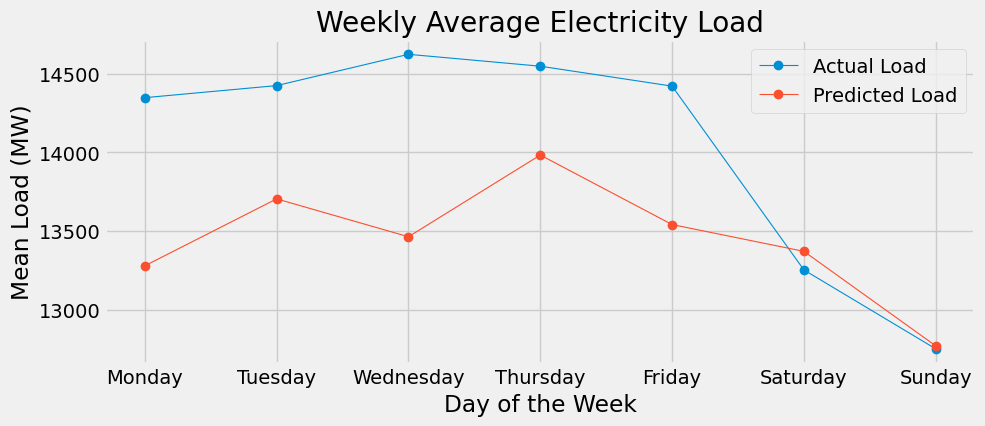

In [1328]:
# Reshape the actual values to have daily values
hourly_actual_values_xgb_multi = np.reshape(y_test, (-1,24))
hourly_predicted_values_xgb_multi = np.reshape(p_test_xgb_tuned, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_xgb_multi = np.mean(hourly_actual_values_xgb_multi, axis=1)
daily_predicted_mean_values_xgb_multi = np.mean(hourly_predicted_values_xgb_multi, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_xgb_multi = daily_actual_mean_values_xgb_multi[2:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_xgb_multi = daily_predicted_mean_values_xgb_multi[2:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_xgb_multi, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_xgb_multi, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("XGB_MULTI_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

# LSTM Model 

In [442]:
import keras
from keras import layers
from keras.layers import LSTM
from bayes_opt import BayesianOptimization
import os
import keras_tuner
import tensorflow as tf
from numpy.random import seed

In [404]:
# define model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
#from kerastuner.keras.tuners import RandomSearch

## LSTM Univariate Multistep

In [673]:
cols = ['Value']
df_for_training_load = his_df[cols].astype(float)

In [1487]:
D = 1095
T = 24
n_window = 3
feature_list = ['Value','WindSpeed','Temperature','PrecipitationAmount','PrecipitationDuration','GlobalRadiation','AirPressure','CloudCover']
n_feature = len(feature_list)
df_eight_fea = df[feature_list].to_numpy()


X = np.zeros((D-n_window, n_window*T, n_feature))
for d in range(n_window,D):
    X[d-n_window,:,:] = df_eight_fea[(d-n_window)*T:d*T,:]

      
y = np.zeros((D-n_window,T))  
for d in range(n_window,D):
    y[d-n_window,:] = df_eight_fea[d*T:(d+1)*T,0]

In [1488]:
X.shape

(1092, 72, 8)

In [1489]:
y.shape

(1092, 24)

In [1490]:
X_train_lstm = X[:910,:,:]
X_val_lstm = X[910:1034,:,:]
X_test_lstm = X[1034:,:,:]
y_train_lstm = y[:910,:]
y_val_lstm = y[910:1034,:]
y_test_lstm = y[1034:,:]

In [1491]:
# Univariate
#======================================================================
# Normalizing
scaler = MinMaxScaler()

X_train_lstm_norm = scaler.fit_transform(X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_val_lstm_norm = scaler.transform(X_val_lstm.reshape(-1, X_val_lstm.shape[-1])).reshape(X_val_lstm.shape)
X_test_lstm_norm = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)

y_min_train, y_max_train = y_train_lstm.min(), y_train_lstm.max()
y_train_lstm_norm = (y_train_lstm-y_min_train)/(y_max_train-y_min_train)
y_val_lstm_norm= (y_val_lstm-y_min_train)/(y_max_train-y_min_train)
y_test_lstm_norm= (y_test_lstm-y_min_train)/(y_max_train-y_min_train)

X_train_lstm_norm = X_train_lstm_norm[:,:,[0]]
X_val_lstm_norm = X_val_lstm_norm[:,:,[0]]
X_test_lstm_norm = X_test_lstm_norm[:,:,[0]]

print(X_train_lstm_norm.shape)
print(y_train_lstm_norm.shape)

(910, 72, 1)
(910, 24)


In [679]:
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [1172]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
model_load = Sequential()
model_load.add(LSTM(96, activation='tanh', input_shape=(X_train_lstm_norm.shape[1],X_train_lstm_norm.shape[2]),return_sequences=True))
model_load.add(Dropout(0.5))
model_load.add(LSTM(64, activation='tanh', return_sequences=False))
model_load.add(Dropout(0.5))
model_load.add(Dense(32, activation='tanh'))
model_load.add(Dense(24))
model_load.compile(optimizer = Adam(learning_rate = 0.0001), loss='mse',metrics = ['mse'])

model_load.summary()

# fit the model
model_load.fit(X_train_lstm_norm, y_train_lstm_norm, validation_data=(X_val_lstm_norm, y_val_lstm_norm), epochs=100)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 72, 96)            40320     
                                                                 
 dropout_24 (Dropout)        (None, 72, 96)            0         
                                                                 
 lstm_25 (LSTM)              (None, 64)                41216     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 24)                792       
                                                                 
Total params: 84,408
Trainable params: 84,408
Non-tra

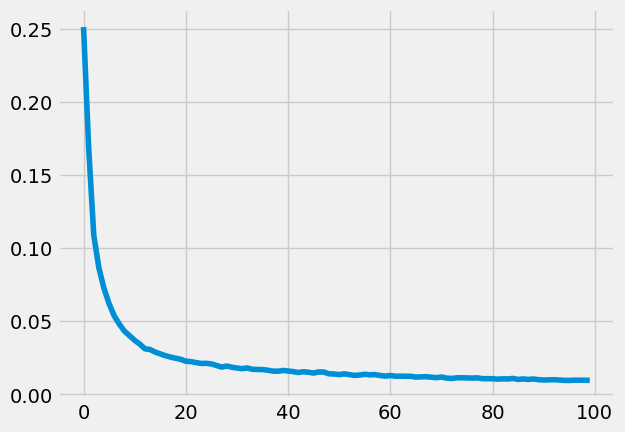

In [1173]:
loss_per_epoch = model_load.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [1174]:
p_train_lstm = model_load.predict(X_train_lstm_norm).flatten()
p_test_lstm = model_load.predict(X_test_lstm_norm).flatten()

2/2 [==============================] - 0s 10ms/step


In [1175]:
MAPE_train_lstm = mean_absolute_percentage_error(y_train_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_train_lstm*(y_max_train-y_min_train)+y_min_train)
MAPE_test_lstm = mean_absolute_percentage_error(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_test_lstm*(y_max_train-y_min_train)+y_min_train)
print(MAPE_train_lstm)
print(MAPE_test_lstm)

0.06622048641889068
0.0747622414077351


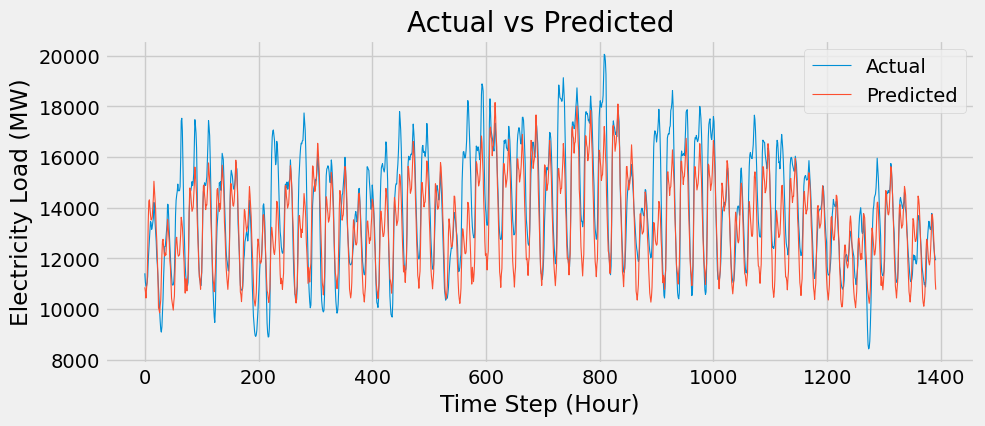

In [1176]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, label='Actual',linewidth=0.8)
plt.plot(p_test_lstm*(y_max_train-y_min_train)+y_min_train, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lstm_load.pdf", bbox_inches = 'tight')
plt.show() 

## Univariate Multistep Hyperparmater Tuning

### https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9

In [308]:
from bayes_opt import BayesianOptimization
import os
import keras_tuner

In [1053]:
import tensorflow as tf
from keras.callbacks import EarlyStopping



def build_model(hp):

    tf.keras.utils.set_random_seed(42)  
    tf.config.experimental.enable_op_determinism()
    
    model_lstm_tuned = Sequential()
    
    model_lstm_tuned.add(LSTM(units=hp.Int('units_lstm_1', min_value=128, max_value=256, step=32),
                              activation='tanh', 
                              input_shape=(X_train_lstm_norm.shape[1], X_train_lstm_norm.shape[2]), 
                              return_sequences=True))
    
    model_lstm_tuned.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))

    model_lstm_tuned.add(LSTM(units=hp.Int('units_lstm_2', min_value=32, max_value=64, step=16), 
                              activation='tanh', 
                              return_sequences=False))
    
    model_lstm_tuned.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    

    model_lstm_tuned.add(Dense(units=hp.Int('units_dense_1', min_value=32, max_value=64, step=32), 
                               activation='tanh'))
    
    model_lstm_tuned.add(Dense(24))
    
    model_lstm_tuned.compile(loss='mse', 
                              metrics=['mse'], 
                              optimizer=keras.optimizers.Adam(learning_rate=0.001))

    return model_lstm_tuned


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create Bayesian Optimization tuner with early stopping callback
bayesian_opt_tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='mse',
    max_trials= 20,
    executions_per_trial=1,
    directory=os.path.normpath('/Users/shanliang/Desktop/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

# Start the search process with early stopping
status = bayesian_opt_tuner.search(X_train_lstm_norm, y_train_lstm_norm, epochs=100,
                                    validation_data=(X_val_lstm_norm, y_val_lstm_norm),
                                    verbose=1, callbacks=[early_stopping])

# Get the best model
bayes_opt_lstm_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
best_lstm_model = bayes_opt_lstm_best_model[0] 

Trial 20 Complete [00h 01m 15s]
mse: 0.005243462976068258

Best mse So Far: 0.005243462976068258
Total elapsed time: 00h 20m 04s


In [1202]:
best_hyperparameters = bayesian_opt_tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

{'units_lstm_1': 224, 'dropout1': 0.4, 'units_lstm_2': 48, 'dropout2': 0.2, 'units_dense_1': 64}


In [1203]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
best_lstm_tuned_reproducible = Sequential()
best_lstm_tuned_reproducible.add(LSTM(224, activation='tanh', input_shape=(X_train_lstm_norm.shape[1],X_train_lstm_norm.shape[2]),return_sequences=True))
best_lstm_tuned_reproducible.add(Dropout(0.4))
best_lstm_tuned_reproducible.add(LSTM(48, activation='tanh', return_sequences=False))
best_lstm_tuned_reproducible.add(Dropout(0.2))
best_lstm_tuned_reproducible.add(Dense(64, activation='tanh'))
best_lstm_tuned_reproducible.add(Dense(24))
best_lstm_tuned_reproducible.compile(optimizer = Adam(learning_rate = 0.01), loss='mse',metrics = ['mse'])
best_lstm_tuned_reproducible.summary()

#  fit the model
start_time = time.time()
history = best_lstm_tuned_reproducible.fit(X_train_lstm_norm, y_train_lstm_norm, validation_data=(X_val_lstm_norm, y_val_lstm_norm), epochs=100)
end_time = time.time()
computational_time = end_time - start_time
p_train_lstm_tuned_reproducible = best_lstm_tuned_reproducible.predict(X_train_lstm_norm).flatten()
p_test_lstm_tuned_reproducible = best_lstm_tuned_reproducible.predict(X_test_lstm_norm).flatten()
print('Computational Time:',computational_time)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 72, 224)           208768    
                                                                 
 dropout_28 (Dropout)        (None, 72, 224)           0         
                                                                 
 lstm_29 (LSTM)              (None, 48)                52416     
                                                                 
 dropout_29 (Dropout)        (None, 48)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                3136      
                                                                 
 dense_29 (Dense)            (None, 24)                1560      
                                                                 
Total params: 265,880
Trainable params: 265,880
Non-t

In [1492]:
MAPE_train_lstm_tuned_reproducible = mean_absolute_percentage_error(y_train_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_train_lstm_tuned_reproducible*(y_max_train-y_min_train)+y_min_train)
MAPE_test_lstm_tuned_reproducible = mean_absolute_percentage_error(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_test_lstm_tuned_reproducible*(y_max_train-y_min_train)+y_min_train)
print(MAPE_train_lstm_tuned_reproducible)
print(MAPE_test_lstm_tuned_reproducible)

0.041058565959564114
0.06642521155716018


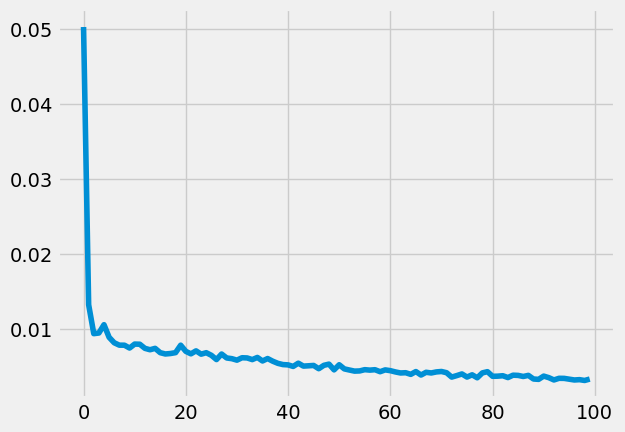

In [1074]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

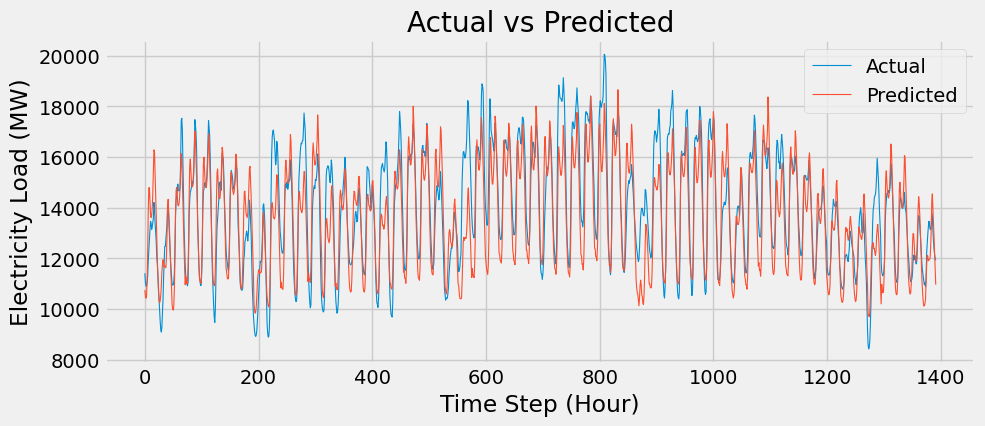

In [1329]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, label='Actual',linewidth=0.8)
plt.plot(p_test_lstm_tuned_reproducible*(y_max_train-y_min_train)+y_min_train, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lstm_load_tuned.pdf", bbox_inches = 'tight')
plt.show() 

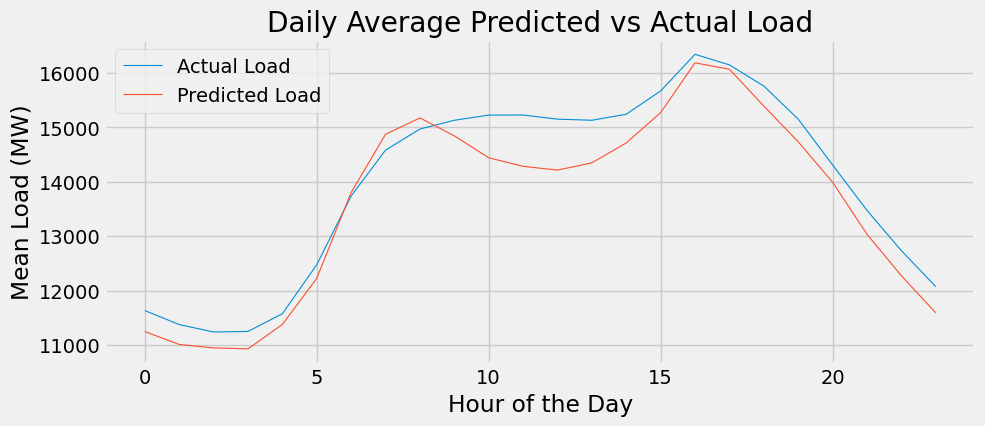

In [1330]:
# Reshape the predicted values to have daily values
daily_predicted_values_lstm_norm = np.reshape(p_test_lstm_tuned_reproducible*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Reshape the actual values to have daily values
daily_actual_values_lstm_norm = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Calculate the mean for each hour
predicted_daily_mean_values_lstm_norm = np.mean(daily_predicted_values_lstm_norm, axis=0)
actual_daily_mean_values_lstm_norm = np.mean(daily_actual_values_lstm_norm, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_lstm_norm, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_lstm_norm, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("LSTM_daily_average_predicted_vs_actual_load.pdf", bbox_inches='tight')
plt.show()

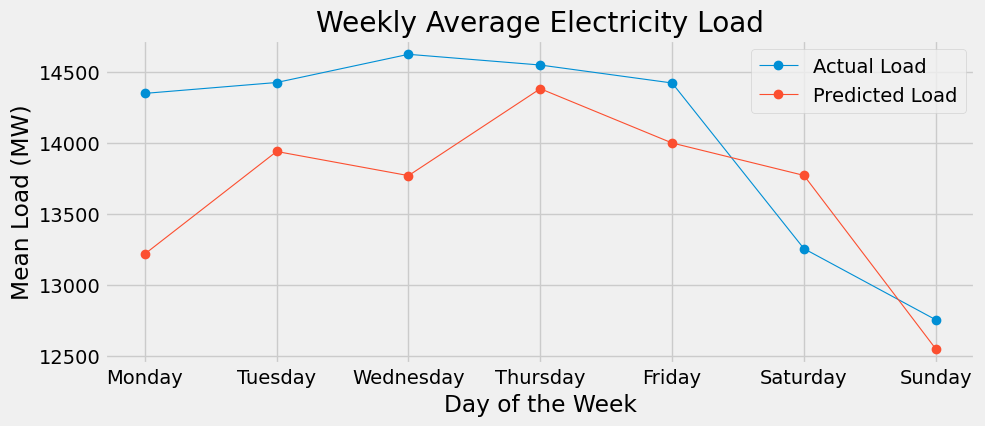

In [1331]:
# Reshape the actual values to have daily values
hourly_actual_values_lstm_load = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1,24))
hourly_predicted_values_lstm_load = np.reshape(p_test_lstm_tuned_reproducible*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_lstm_load = np.mean(hourly_actual_values_lstm_load, axis=1)
daily_predicted_mean_values_lstm_load = np.mean(hourly_predicted_values_lstm_load, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_lstm_load = daily_actual_mean_values_lstm_load[2:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_lstm_load = daily_predicted_mean_values_lstm_load[2:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_lstm_load, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_lstm_load, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("LSTM_LOAD_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

## LSTM Multivariate Multistep

In [687]:
D = 1095
T = 24
n_window = 3
feature_list = ['Value','WindSpeed','Temperature','PrecipitationAmount','PrecipitationDuration','GlobalRadiation','AirPressure','CloudCover']
n_feature = len(feature_list)
df_eight_fea = df[feature_list].to_numpy()


X = np.zeros((D-n_window, n_window*T, n_feature))
for d in range(n_window,D):
    X[d-n_window,:,:] = df_eight_fea[(d-n_window)*T:d*T,:]

      
y = np.zeros((D-n_window,T))  
for d in range(n_window,D):
    y[d-n_window,:] = df_eight_fea[d*T:(d+1)*T,0]


X_train_lstm = X[:910,:,:]
X_val_lstm = X[910:1034,:,:]
X_test_lstm = X[1034:,:,:]
y_train_lstm = y[:910,:]
y_val_lstm = y[910:1034,:]
y_test_lstm = y[1034:,:]

In [688]:
# Multivariate
#======================================================================
# Normalizing
scaler = MinMaxScaler()

X_train_lstm_norm = scaler.fit_transform(X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_val_lstm_norm = scaler.transform(X_val_lstm.reshape(-1, X_val_lstm.shape[-1])).reshape(X_val_lstm.shape)
X_test_lstm_norm = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)

y_min_train, y_max_train = y_train_lstm.min(), y_train_lstm.max()
y_train_lstm_norm = (y_train_lstm-y_min_train)/(y_max_train-y_min_train)
y_val_lstm_norm= (y_val_lstm-y_min_train)/(y_max_train-y_min_train)
y_test_lstm_norm= (y_test_lstm-y_min_train)/(y_max_train-y_min_train)

X_train_lstm_norm = X_train_lstm_norm[:,:,:]
X_val_lstm_norm = X_val_lstm_norm[:,:,:]
X_test_lstm_norm = X_test_lstm_norm[:,:,:]

print(X_train_lstm_norm.shape)
print(y_train_lstm_norm.shape)

(910, 72, 8)
(910, 24)


In [1168]:
import tensorflow
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
model_multi = Sequential()
model_multi.add(LSTM(128, activation='tanh', input_shape=(X_train_lstm_norm.shape[1],X_train_lstm_norm.shape[2]),return_sequences=True))
model_multi.add(Dropout(0.5))
model_multi.add(LSTM(64, activation='tanh', return_sequences=False))
model_multi.add(Dropout(0.1))
model_multi.add(Dense(32, activation='tanh'))
model_multi.add(Dense(24))
model_multi.compile(optimizer = Adam(learning_rate = 0.0001), loss='mse',metrics = ['mse'])
model_multi.summary()

model_multi.fit(X_train_lstm_norm, y_train_lstm_norm, validation_data=(X_val_lstm_norm, y_val_lstm_norm), epochs=100)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 72, 128)           70144     
                                                                 
 dropout_22 (Dropout)        (None, 72, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 24)                792       
                                                                 
Total params: 122,424
Trainable params: 122,424
Non-t

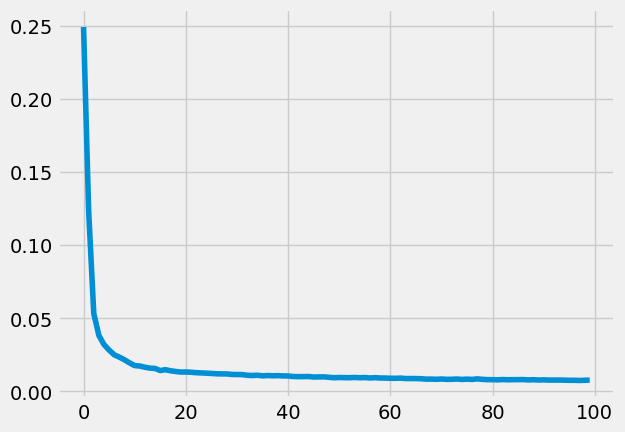

In [1169]:
loss_per_epoch = model_multi.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [1170]:
p_train_lstm_multi = model_multi.predict(X_train_lstm_norm).flatten()
p_test_lstm_multi = model_multi.predict(X_test_lstm_norm).flatten()

2/2 [==============================] - 0s 12ms/step


In [1171]:
MAPE_train_lstm_multi = mean_absolute_percentage_error(y_train_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_train_lstm_multi*(y_max_train-y_min_train)+y_min_train)
MAPE_test_lstm_multi = mean_absolute_percentage_error(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_test_lstm_multi*(y_max_train-y_min_train)+y_min_train)
print(MAPE_train_lstm_multi)
print(MAPE_test_lstm_multi)

0.06142039570686849
0.07517971809164115


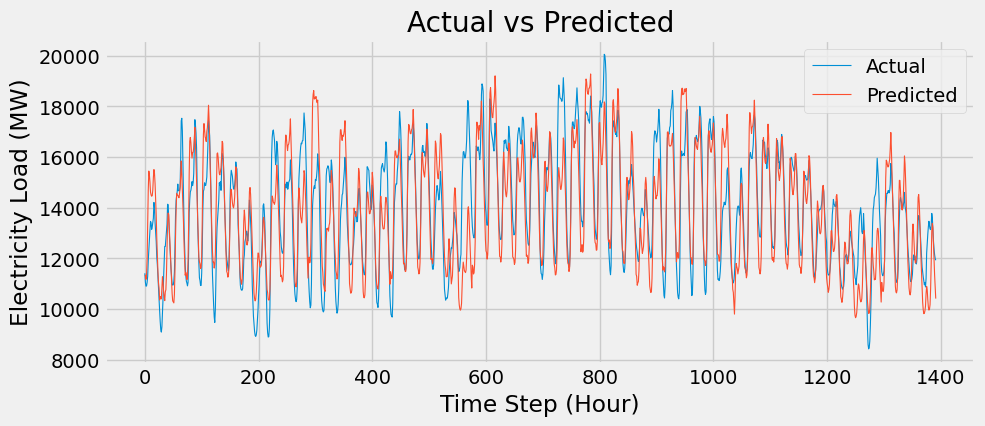

In [1124]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, label='Actual',linewidth=0.8)
plt.plot(p_test_lstm_multi*(y_max_train-y_min_train)+y_min_train, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lstm_multi.pdf", bbox_inches = 'tight')
plt.show() 

## LSTM Multivariate Multistep Hyperparameter Tuning 

In [1099]:
## Hyperparameter Tuning -- Multivariate

# Set random seed for numpy and tensorflow
import tensorflow

tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

# Define the function to build the LSTM model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def build_model(hp):
    lstm_multi_tuned = Sequential()
    lstm_multi_tuned.add(LSTM(units=hp.Int('units_lstm_1', min_value=256, max_value=352, step=32),
                              activation='tanh', input_shape=(X_train_lstm_norm.shape[1], X_train_lstm_norm.shape[2]), 
                              return_sequences=True))
    lstm_multi_tuned.add(Dropout(hp.Float('droput1', min_value=0.1, max_value=0.5, step=0.1)))
    lstm_multi_tuned.add(LSTM(units=hp.Int('units_lstm_2', min_value=32, max_value=96, step=32), activation='tanh', return_sequences=False))
    lstm_multi_tuned.add(Dropout(hp.Float('droput2', min_value=0.1, max_value=0.5, step=0.1)))
    lstm_multi_tuned.add(Dense(hp.Int('units_dense_1', min_value=32, max_value=64, step=32), activation='tanh'))
    lstm_multi_tuned.add(Dense(24))
    lstm_multi_tuned.compile(loss='mse', 
                              metrics=['mse'], 
                              optimizer=keras.optimizers.Adam(learning_rate = 0.001))

    return lstm_multi_tuned



# Define the Bayesian Optimization tuner
bayesian_opt_tuner_multi = keras_tuner.BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=20,
    executions_per_trial=1,
    directory=os.path.normpath('/Users/shanliang/Desktop/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True
)

# Perform hyperparameter search
history = bayesian_opt_tuner_multi.search(X_train_lstm_norm, y_train_lstm_norm, epochs=100,
                                    validation_data=(X_val_lstm_norm, y_val_lstm_norm),
                                    verbose=1)

# Get the best model
best_lstm_model_multi = bayesian_opt_tuner_multi.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hyperparameters_multi = bayesian_opt_tuner_multi.get_best_hyperparameters()[0]
print(best_hyperparameters_multi.values)


Trial 20 Complete [00h 04m 08s]
mse: 0.0034989805426448584

Best mse So Far: 0.003325709141790867
Total elapsed time: 01h 38m 49s
{'units_lstm_1': 352, 'droput1': 0.30000000000000004, 'units_lstm_2': 96, 'droput2': 0.1, 'units_dense_1': 64}


In [1206]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
best_lstm_model_multi_reproducible = Sequential()
best_lstm_model_multi_reproducible.add(LSTM(352, activation='tanh', input_shape=(X_train_lstm_norm.shape[1],X_train_lstm_norm.shape[2]),return_sequences=True))
best_lstm_model_multi_reproducible.add(Dropout(0.30000000000000004))
best_lstm_model_multi_reproducible.add(LSTM(96, activation='tanh', return_sequences=False))
best_lstm_model_multi_reproducible.add(Dropout(0.1))
best_lstm_model_multi_reproducible.add(Dense(64, activation='tanh'))
best_lstm_model_multi_reproducible.add(Dense(24))
best_lstm_model_multi_reproducible.compile(optimizer = Adam(learning_rate = 0.001), loss='mse',metrics = ['mse'])
best_lstm_model_multi_reproducible.summary()

# fit the model
start_time = time.time()
history_best_lstm_model_multi_reproducible = best_lstm_model_multi_reproducible.fit(X_train_lstm_norm, y_train_lstm_norm, validation_data=(X_val_lstm_norm, y_val_lstm_norm), epochs=100)
end_time = time.time()
computational_time = end_time - start_time
print('Computational Time:',computational_time )

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 72, 352)           508288    
                                                                 
 dropout_30 (Dropout)        (None, 72, 352)           0         
                                                                 
 lstm_31 (LSTM)              (None, 96)                172416    
                                                                 
 dropout_31 (Dropout)        (None, 96)                0         
                                                                 
 dense_30 (Dense)            (None, 64)                6208      
                                                                 
 dense_31 (Dense)            (None, 24)                1560      
                                                                 
Total params: 688,472
Trainable params: 688,472
Non-t

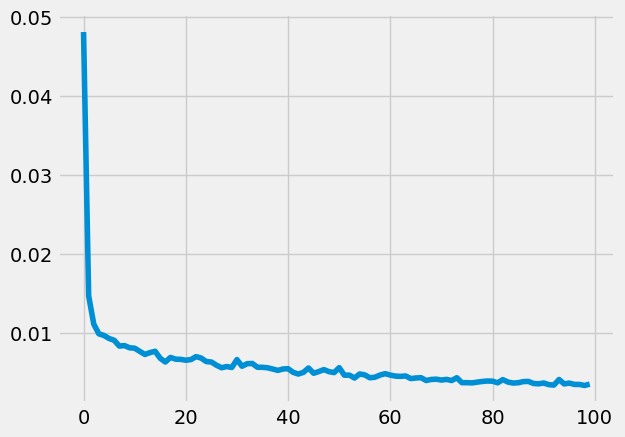

In [1207]:
loss_per_epoch = history_best_lstm_model_multi_reproducible.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [1208]:
p_train_lstm_multi_tuned_reproducible = best_lstm_model_multi_reproducible.predict(X_train_lstm_norm).flatten()
p_test_lstm_multi_tuned_reproducible = best_lstm_model_multi_reproducible.predict(X_test_lstm_norm).flatten()

2/2 [==============================] - 0s 27ms/step


In [1209]:
MAPE_train_lstm_multi_tuned_reproducible = mean_absolute_percentage_error(y_train_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_train_lstm_multi_tuned_reproducible*(y_max_train-y_min_train)+y_min_train)
MAPE_test_lstm_multi_tuned_reproducible = mean_absolute_percentage_error(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_test_lstm_multi_tuned_reproducible*(y_max_train-y_min_train)+y_min_train)
print(MAPE_train_lstm_multi_tuned_reproducible)
print(MAPE_test_lstm_multi_tuned_reproducible)

0.04398447387831183
0.06959866225476855


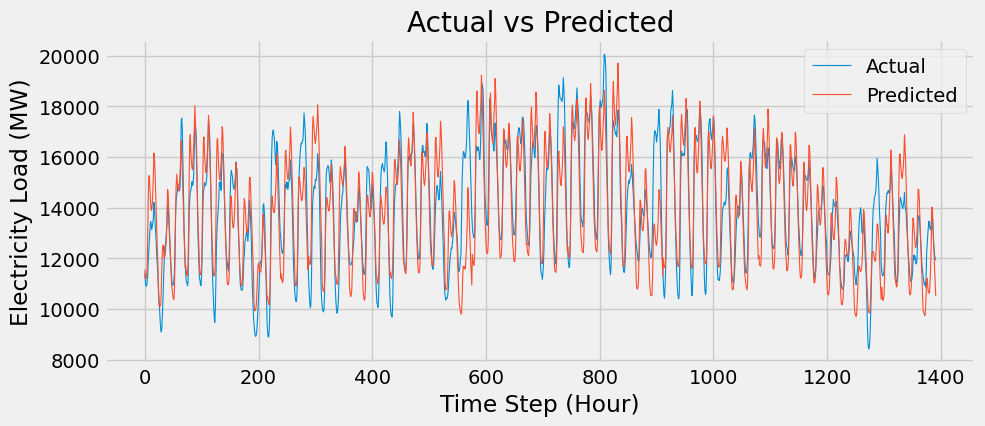

In [1332]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, label='Actual',linewidth=0.8)
plt.plot(p_test_lstm_multi_tuned_reproducible*(y_max_train-y_min_train)+y_min_train, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lstm_multi.pdf", bbox_inches = 'tight')
plt.show() 

## Feature Importance

### https://www.kaggle.com/code/ltsmssv/shap-for-lstm-hpccv2

In [1108]:
# Create the GradientExplainer
explainer_lstm_GradientExplainer = shap.GradientExplainer(best_lstm_model_multi, X_train_lstm_norm[:100,:,:])

# Compute SHAP values
shap_values_lstm_GradientExplainer = explainer_lstm_GradientExplainer.shap_values(X_train_lstm_norm[:100,:,:])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [1109]:
shap_values_lstm_GradientExplainer[0].shape

(100, 72, 8)

In [1110]:
shap_values_lstm_GradientExplainer_2D = shap_values_lstm_GradientExplainer[0].reshape(-1,8)
print(shap_values_lstm_GradientExplainer_2D.shape)
X_train_lstm_norm_2D_try = X_train_lstm_norm[:100,:,:].reshape(-1,8)
print(X_train_lstm_norm_2D_try.shape)

(7200, 8)
(7200, 8)


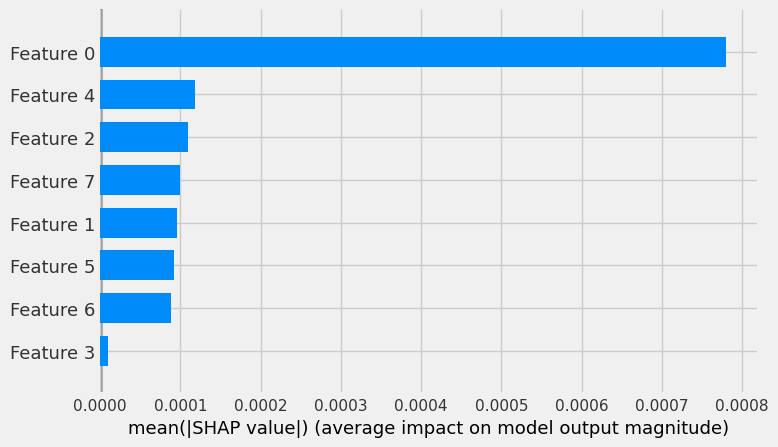

In [1111]:
shap.summary_plot(shap_values_lstm_2D_try, X_train_lstm_norm_2D_try, plot_type="bar")

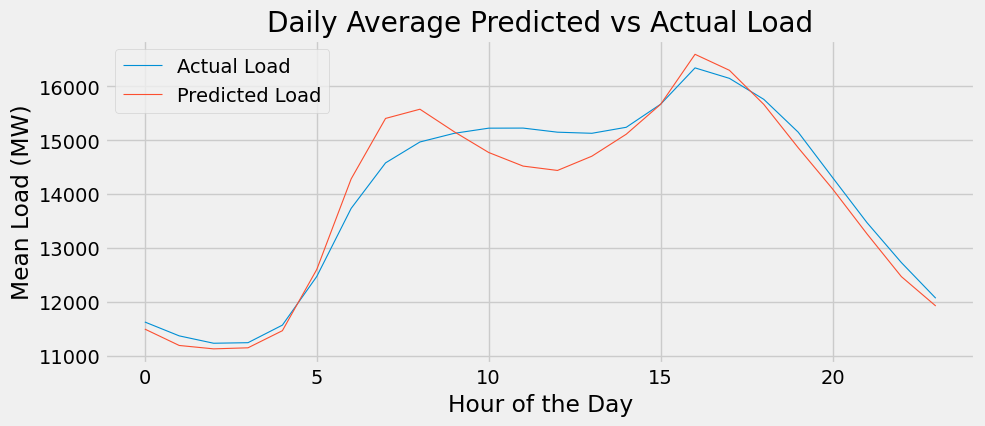

In [1333]:
# Reshape the predicted values to have daily values
daily_predicted_values_lstm = np.reshape(p_test_lstm_multi_tuned_reproducible*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Reshape the actual values to have daily values
daily_actual_values_lstm = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Calculate the mean for each hour
predicted_daily_mean_values_lstm = np.mean(daily_predicted_values_lstm, axis=0)
actual_daily_mean_values_lstm = np.mean(daily_actual_values_lstm, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_lstm, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_lstm, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("LSTM_daily_average_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

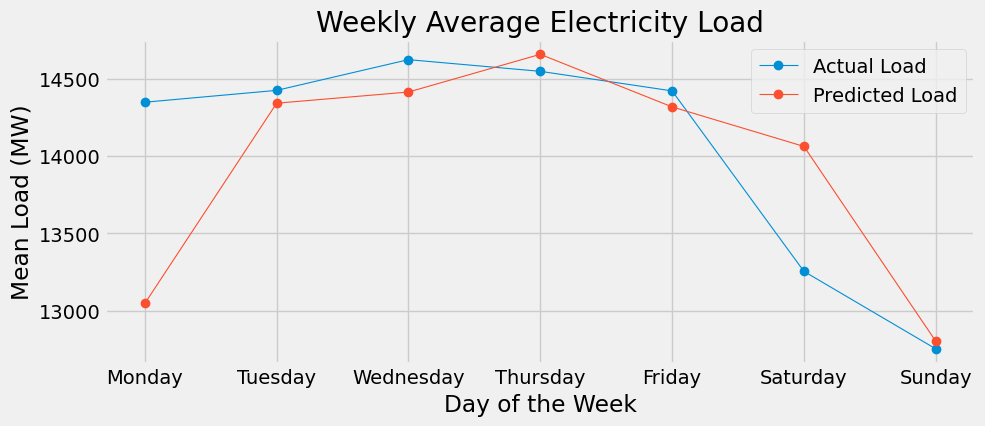

In [1334]:
# Reshape the actual values to have daily values
hourly_actual_values_lstm_multi = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1,24))
hourly_predicted_values_lstm_multi = np.reshape(p_test_lstm_multi_tuned_reproducible*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_lstm_multi = np.mean(hourly_actual_values_lstm_multi, axis=1)
daily_predicted_mean_values_lstm_multi = np.mean(hourly_predicted_values_lstm_multi, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_lstm_multi = daily_actual_mean_values_lstm_multi[2:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_lstm_multi = daily_predicted_mean_values_lstm_multi[2:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_lstm_multi, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_lstm_multi, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("LSTM_MULTI_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

# 7 days LSTM Univariate Multistep

In [1498]:
D = 1095
T = 24
n_window = 7
feature_list = ['Value','WindSpeed','Temperature','PrecipitationAmount','PrecipitationDuration','GlobalRadiation','AirPressure','CloudCover']
n_feature = len(feature_list)
df_eight_fea = df[feature_list].to_numpy()


X = np.zeros((D-n_window, n_window*T, n_feature))
for d in range(n_window,D):
    X[d-n_window,:,:] = df_eight_fea[(d-n_window)*T:d*T,:]

      
y = np.zeros((D-n_window,T))  
for d in range(n_window,D):
    y[d-n_window,:] = df_eight_fea[d*T:(d+1)*T,0]

In [1499]:
X_train_lstm = X[:910,:,:]
X_val_lstm = X[910:1034,:,:]
X_test_lstm = X[1034:,:,:]
y_train_lstm = y[:910,:]
y_val_lstm = y[910:1034,:]
y_test_lstm = y[1034:,:]

In [1500]:
# Univariate
#======================================================================
# Normalizing
scaler = MinMaxScaler()

X_train_lstm_norm = scaler.fit_transform(X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_val_lstm_norm = scaler.transform(X_val_lstm.reshape(-1, X_val_lstm.shape[-1])).reshape(X_val_lstm.shape)
X_test_lstm_norm = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)

y_min_train, y_max_train = y_train_lstm.min(), y_train_lstm.max()
y_train_lstm_norm = (y_train_lstm-y_min_train)/(y_max_train-y_min_train)
y_val_lstm_norm= (y_val_lstm-y_min_train)/(y_max_train-y_min_train)
y_test_lstm_norm= (y_test_lstm-y_min_train)/(y_max_train-y_min_train)

X_train_lstm_norm = X_train_lstm_norm[:,:,[0]]
X_val_lstm_norm = X_val_lstm_norm[:,:,[0]]
X_test_lstm_norm = X_test_lstm_norm[:,:,[0]]

print(X_train_lstm_norm.shape)
print(y_train_lstm_norm.shape)

(910, 168, 1)
(910, 24)


In [1391]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
model_lstm7 = Sequential()
model_lstm7.add(LSTM(64, activation='tanh', input_shape=(X_train_lstm_norm.shape[1],X_train_lstm_norm.shape[2]),return_sequences=True))
model_lstm7.add(Dropout(0.5))
model_lstm7.add(LSTM(64, activation='tanh', return_sequences=False))
model_lstm7.add(Dropout(0.5))
model_lstm7.add(Dense(32, activation='tanh'))
model_lstm7.add(Dense(24))
model_lstm7.compile(optimizer = Adam(learning_rate = 0.01), loss='mse',metrics = ['mse'])

model_lstm7.summary()

# fit the model
model_lstm7.fit(X_train_lstm_norm, y_train_lstm_norm, validation_data=(X_val_lstm_norm, y_val_lstm_norm), epochs=100)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 168, 64)           16896     
                                                                 
 dropout_48 (Dropout)        (None, 168, 64)           0         
                                                                 
 lstm_49 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 24)                792       
                                                                 
Total params: 52,792
Trainable params: 52,792
Non-tra

In [1392]:
p_train_lstm7 = model_lstm7.predict(X_train_lstm_norm).flatten()
p_test_lstm7 = model_lstm7.predict(X_test_lstm_norm).flatten()

2/2 [==============================] - 0s 15ms/step


In [1393]:
MAPE_train_lstm7 = mean_absolute_percentage_error(y_train_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_train_lstm7*(y_max_train-y_min_train)+y_min_train)
MAPE_test_lstm7 = mean_absolute_percentage_error(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_test_lstm7*(y_max_train-y_min_train)+y_min_train)
print(MAPE_train_lstm7)
print(MAPE_test_lstm7)

0.06037994708835853
0.06850087585408758


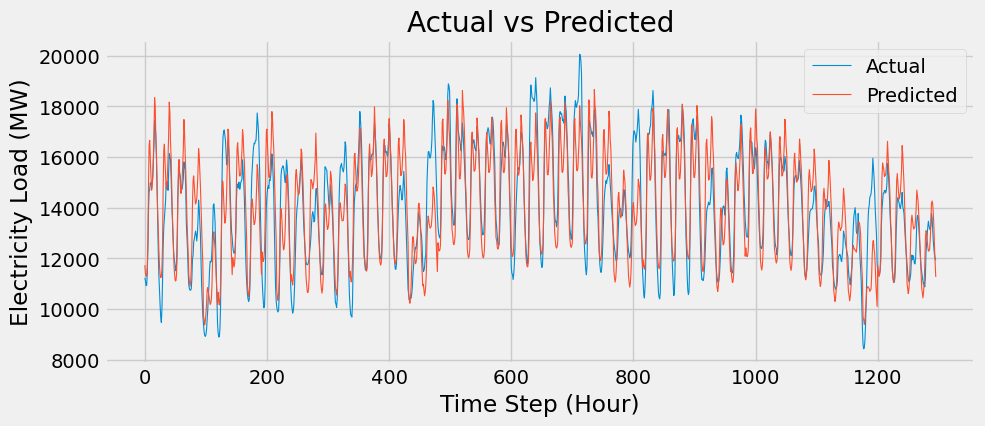

In [1520]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, label='Actual',linewidth=0.8)
plt.plot(p_test_lstm7*(y_max_train-y_min_train)+y_min_train, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig("lstm_multi.pdf", bbox_inches = 'tight')
plt.show() 

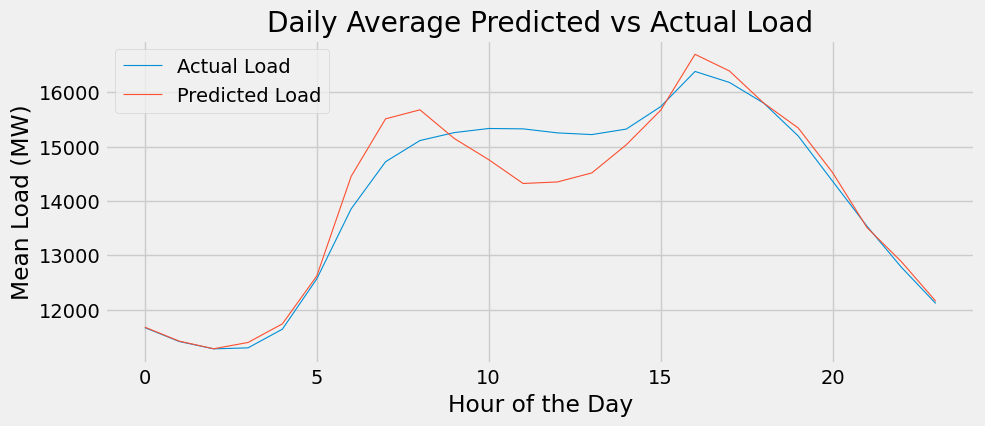

In [1521]:
# Reshape the predicted values to have daily values
daily_actual_values_lstm7 = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Reshape the actual values to have daily values
daily_predicted_values_lstm7 = np.reshape(p_test_lstm7*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Calculate the mean for each hour
actual_daily_mean_values_lstm7 = np.mean(daily_actual_values_lstm7, axis=0)
predicted_daily_mean_values_lstm7 = np.mean(daily_predicted_values_lstm7, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_lstm7, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_lstm7, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
#plt.savefig("LSTM_daily_average_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

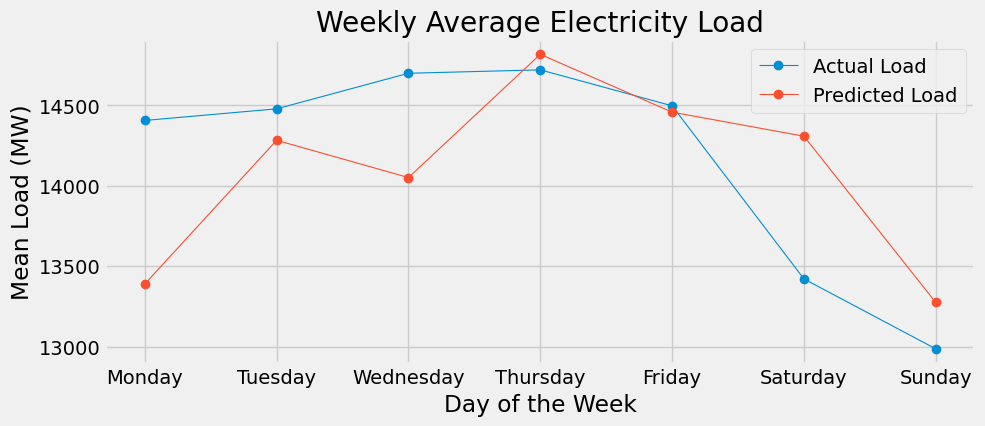

In [1522]:
# Reshape the actual values to have daily values
hourly_actual_values_lstm7 = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1,24))
hourly_predicted_values_lstm7 = np.reshape(p_test_lstm7*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_lstm7 = np.mean(hourly_actual_values_lstm7, axis=1)
daily_predicted_mean_values_lstm7 = np.mean(hourly_predicted_values_lstm7, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_lstm7 = daily_actual_mean_values_lstm7[5:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_lstm7 = daily_predicted_mean_values_lstm7[5:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_lstm7, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_lstm7, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
#plt.savefig("LSTM_MULTI_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

## 7 days LSTM Univariate Multistep Hyperparameter Tuning

In [1468]:

def build_model(hp):

    tf.keras.utils.set_random_seed(42)  
    tf.config.experimental.enable_op_determinism()
    
    model_lstm7_tuned = Sequential()
    
    model_lstm7_tuned.add(LSTM(units=hp.Int('units_lstm_1', min_value=32, max_value=128, step=16),
                              activation='tanh', 
                              input_shape=(X_train_lstm_norm.shape[1], X_train_lstm_norm.shape[2]), 
                              return_sequences=True))
    
    model_lstm7_tuned.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.8, step=0.1)))

    model_lstm7_tuned.add(LSTM(units=hp.Int('units_lstm_2', min_value=32, max_value=96, step=16), 
                              activation='tanh', 
                              return_sequences=True))
    
    model_lstm7_tuned.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.8, step=0.1)))
    
    model_lstm7_tuned.add(LSTM(units=hp.Int('units_lstm_3', min_value=32, max_value=64, step=16), 
                              activation='tanh', 
                              return_sequences=False))
    
    model_lstm7_tuned.add(Dropout(hp.Float('dropout3', min_value=0.1, max_value=0.8, step=0.1)))
    
    model_lstm7_tuned.add(Dense(units=hp.Int('units_dense_1', min_value=32, max_value=64, step=32), 
                               activation='tanh'))
    
    model_lstm7_tuned.add(Dense(24))
    
    model_lstm7_tuned.compile(loss='mse', 
                              metrics=['mse'], 
                              optimizer=keras.optimizers.Adam(learning_rate=0.001))

    return model_lstm7_tuned


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create Bayesian Optimization tuner with early stopping callback
bayesian_opt_tuner7 = keras_tuner.BayesianOptimization(
    build_model,
    objective='mse',
    max_trials= 20,
    executions_per_trial=1,
    directory=os.path.normpath('/Users/shanliang/Desktop/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

# Start the search process with early stopping
status = bayesian_opt_tuner7.search(X_train_lstm_norm, y_train_lstm_norm, epochs=100,
                                    validation_data=(X_val_lstm_norm, y_val_lstm_norm),
                                    verbose=1, callbacks=[early_stopping])

# Get the best model
bayes_opt_lstm7_best_model = bayesian_opt_tuner7.get_best_models(num_models=1)
best_lstm7_model = bayes_opt_lstm7_best_model[0] 

Trial 20 Complete [00h 01m 23s]
mse: 0.007675966247916222

Best mse So Far: 0.004453090950846672
Total elapsed time: 00h 32m 20s


In [1469]:
best_hyperparameters7 = bayesian_opt_tuner7.get_best_hyperparameters()[0]
print(best_hyperparameters7.values)

{'units_lstm_1': 48, 'dropout1': 0.1, 'units_lstm_2': 48, 'dropout2': 0.1, 'units_lstm_3': 48, 'dropout3': 0.1, 'units_dense_1': 64}


In [1470]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
best_lstm7_tuned_reproducible = Sequential()
best_lstm7_tuned_reproducible.add(LSTM(48, activation='tanh', input_shape=(X_train_lstm_norm.shape[1],X_train_lstm_norm.shape[2]),return_sequences=True))
best_lstm7_tuned_reproducible.add(Dropout(0.1))
best_lstm7_tuned_reproducible.add(LSTM(48, activation='tanh', return_sequences=True))
best_lstm7_tuned_reproducible.add(Dropout(0.1))
best_lstm7_tuned_reproducible.add(LSTM(48, activation='tanh', return_sequences=False))
best_lstm7_tuned_reproducible.add(Dropout(0.1))
best_lstm7_tuned_reproducible.add(Dense(64, activation='tanh'))
best_lstm7_tuned_reproducible.add(Dense(24))
best_lstm7_tuned_reproducible.compile(optimizer = Adam(learning_rate = 0.001), loss='mse',metrics = ['mse'])
best_lstm7_tuned_reproducible.summary()

#  fit the model
start_time = time.time()
history = best_lstm7_tuned_reproducible.fit(X_train_lstm_norm, y_train_lstm_norm, validation_data=(X_val_lstm_norm, y_val_lstm_norm), epochs=100)
end_time = time.time()
computational_time = end_time - start_time
p_train_lstm7_tuned_reproducible = best_lstm7_tuned_reproducible.predict(X_train_lstm_norm).flatten()
p_test_lstm7_tuned_reproducible = best_lstm7_tuned_reproducible.predict(X_test_lstm_norm).flatten()
print('Computational Time:',computational_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 168, 48)           9600      
                                                                 
 dropout_3 (Dropout)         (None, 168, 48)           0         
                                                                 
 lstm_4 (LSTM)               (None, 168, 48)           18624     
                                                                 
 dropout_4 (Dropout)         (None, 168, 48)           0         
                                                                 
 lstm_5 (LSTM)               (None, 48)                18624     
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [1471]:
p_train_lstm7_tuned = best_lstm7_tuned_reproducible.predict(X_train_lstm_norm).flatten()
p_test_lstm7_tuned = best_lstm7_tuned_reproducible.predict(X_test_lstm_norm).flatten()

2/2 [==============================] - 0s 16ms/step


In [1501]:
MAPE_train_lstm7_tuned = mean_absolute_percentage_error(y_train_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_train_lstm7_tuned*(y_max_train-y_min_train)+y_min_train)
MAPE_test_lstm7_tuned = mean_absolute_percentage_error(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, p_test_lstm7_tuned*(y_max_train-y_min_train)+y_min_train)
print(MAPE_train_lstm7_tuned)
print(MAPE_test_lstm7_tuned)

0.04822901896836229
0.0663176223974881


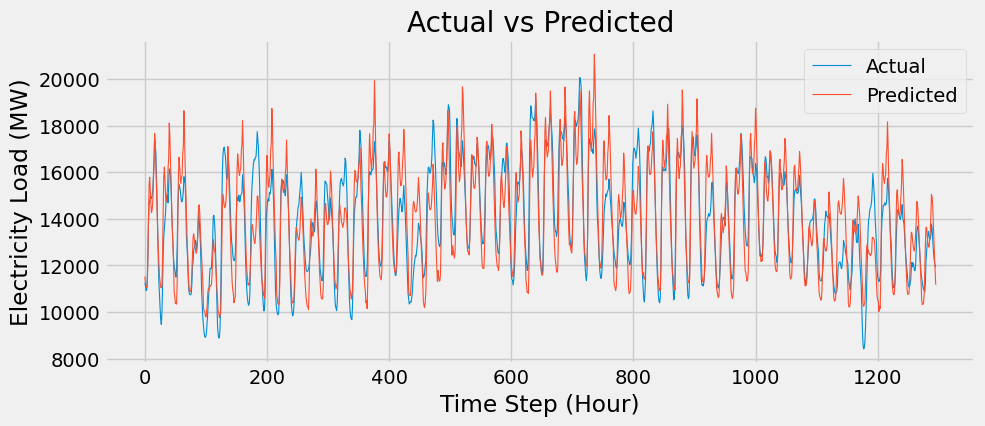

In [1506]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, label='Actual',linewidth=0.8)
plt.plot(p_test_lstm7_tuned*(y_max_train-y_min_train)+y_min_train, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("lstm_multi_7days.pdf", bbox_inches = 'tight')
plt.show() 

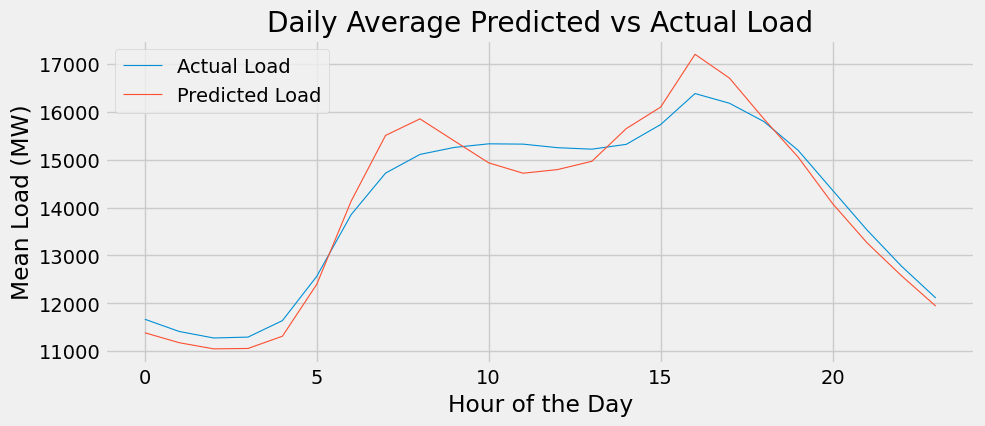

In [1515]:
# Reshape the predicted values to have daily values
daily_actual_values_lstm7 = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Reshape the actual values to have daily values
daily_predicted_values_lstm7 = np.reshape(p_test_lstm7_tuned*(y_max_train-y_min_train)+y_min_train, (-1, 24)) 

# Calculate the mean for each hour
actual_daily_mean_values_lstm7 = np.mean(daily_actual_values_lstm7, axis=0)
predicted_daily_mean_values_lstm7 = np.mean(daily_predicted_values_lstm7, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual_daily_mean_values_lstm7, label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted_daily_mean_values_lstm7, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("LSTM7_daily_average_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

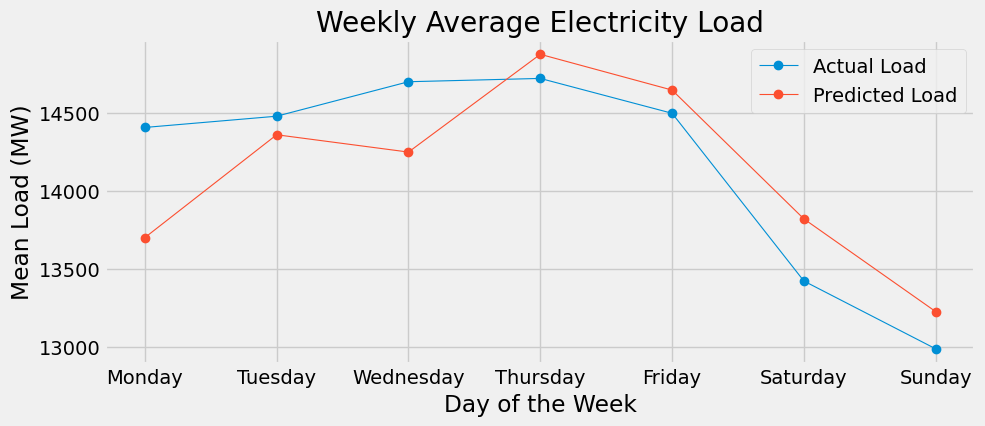

In [1508]:
# Reshape the actual values to have daily values
hourly_actual_values_lstm7 = np.reshape(y_test_lstm_norm.flatten()*(y_max_train-y_min_train)+y_min_train, (-1,24))
hourly_predicted_values_lstm7 = np.reshape(p_test_lstm7_tuned*(y_max_train-y_min_train)+y_min_train, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual_mean_values_lstm7 = np.mean(hourly_actual_values_lstm7, axis=1)
daily_predicted_mean_values_lstm7 = np.mean(hourly_predicted_values_lstm7, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual_mean_values_lstm7 = daily_actual_mean_values_lstm7[5:].reshape((-1,7)).mean(axis=0)
weekly_predicted_mean_values_lstm7 = daily_predicted_mean_values_lstm7[5:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual_mean_values_lstm7, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted_mean_values_lstm7, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("LSTM7_MULTI_Weekly Average Electricity Loadl.pdf", bbox_inches='tight')
# Show plot
plt.show()

# Persistent Forecast

In [1510]:
y_persist = y_target[1033*24:-24]
mape_y_persistent = mean_absolute_percentage_error(y_persist, y_test)
print(mape_y_persistent)

0.07777471333228053


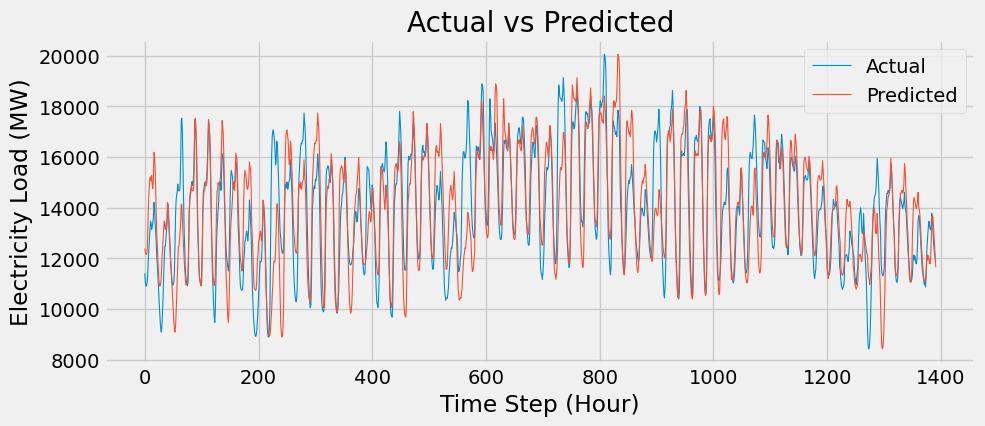

In [1516]:
# Plot the actual values and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual',linewidth=0.8)
plt.plot(y_persist, label='Predicted',linewidth=0.8)

# Add labels and legend
plt.xlabel('Time Step (Hour)')
plt.ylabel('Electricity Load (MW)')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig("persistent forecast.pdf", bbox_inches = 'tight')
plt.show() 

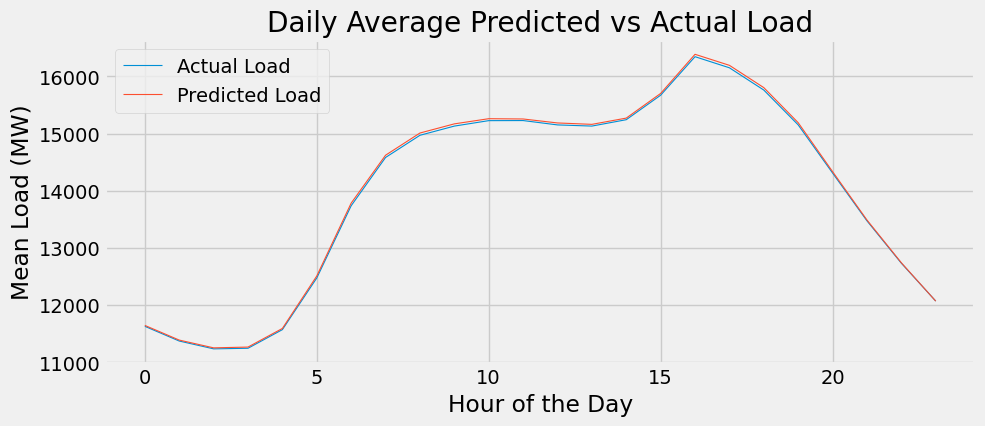

In [1517]:
# Reshape the predicted values to have daily values
daily_actual_values = np.reshape(y_test, (-1, 24))

# Reshape the actual values to have daily values
daily_predicted_forecast = np.reshape(y_persist, (-1, 24))

# Calculate the mean for each hour
actual = np.mean(daily_actual_values, axis=0)
predicted = np.mean(daily_predicted_forecast, axis=0)

# Plot the daily average load values
plt.figure(figsize=(10, 4))
plt.plot(actual , label='Actual Load', linewidth=0.8)  # Plot actual load first
plt.plot(predicted, label='Predicted Load', linewidth=0.8)  # Then plot predicted load

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Load (MW)')
plt.title('Daily Average Predicted vs Actual Load')
plt.legend()
plt.grid(True)
plt.savefig("persistent forecast daily.pdf", bbox_inches='tight')
plt.show()

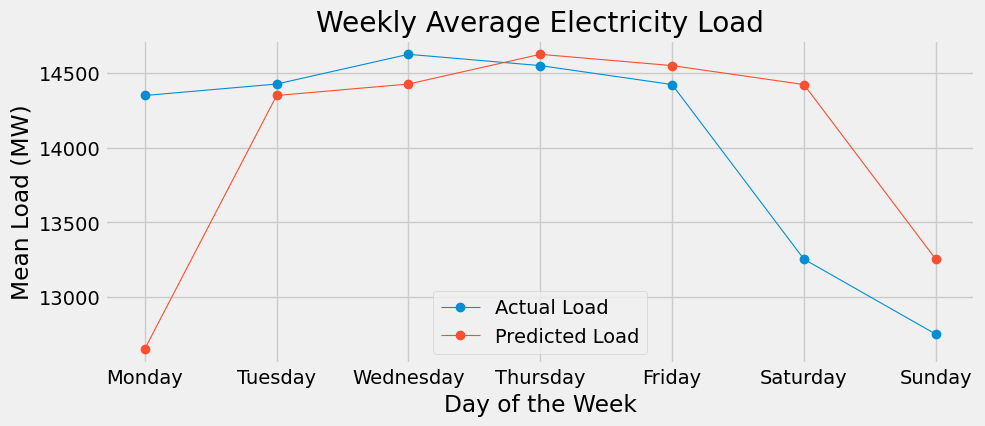

In [1514]:
# Reshape the actual values to have daily values
hourly_actual = np.reshape(y_test, (-1,24))
hourly_predicted = np.reshape(y_persist, (-1, 24))

# Calculate the mean for each day for actual values
daily_actual = np.mean(hourly_actual, axis=1)
daily_predicted = np.mean(hourly_predicted, axis=1)

# Group the mean actual values by day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_actual = daily_actual[2:].reshape((-1,7)).mean(axis=0)
weekly_predicted = daily_predicted[2:].reshape((-1,7)).mean(axis=0)


# Plot the weekly average load values
plt.figure(figsize=(10, 4))
plt.plot(days_of_week, weekly_actual, marker='o', label='Actual Load',linewidth=0.8)
plt.plot(days_of_week, weekly_predicted, marker='o', label='Predicted Load',linewidth=0.8)

# Add labels, title, legend, and grid
plt.xlabel('Day of the Week')
plt.ylabel('Mean Load (MW)')
plt.title('Weekly Average Electricity Load')
plt.legend()
plt.grid(True)
plt.savefig("persistent forecast weekly.pdf", bbox_inches='tight')
# Show plot
plt.show()